In [1]:
from datetime import datetime
from itertools import combinations
import os
import re

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn as sk
import mlflow
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

import data_proc as dp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [2]:
REMOTE_TRACKING_IP = os.getenv("REMOTE_IP", "localhost")
MLFLOW_TRACKING_URI = f"http://{REMOTE_TRACKING_IP}:5000"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

CREDIT_EXPERIMENT_NAME = "credit-score-chrono"
EXPERIMENT_NAME = "chosen-models-credit"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(CREDIT_EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/590077062623295170', creation_time=1713441579386, experiment_id='590077062623295170', last_update_time=1713441579386, lifecycle_stage='active', name='credit-score-chrono', tags={}>

In [5]:
(base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
cat_cols_base = list(X_train.select_dtypes("category").columns)

In [11]:
data = pl.read_parquet("data/train_base.parquet", use_pyarrow = True).to_pandas()

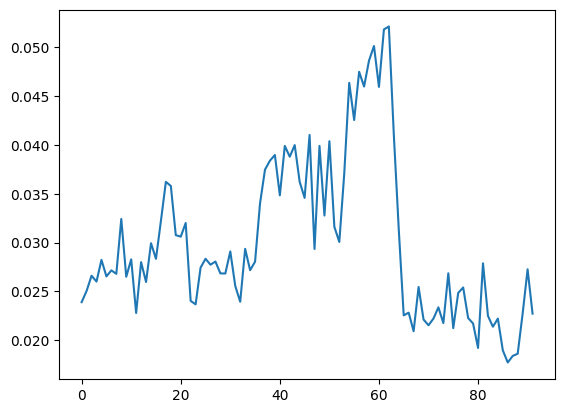

In [22]:
plt.plot(data.sort_values("WEEK_NUM").groupby("WEEK_NUM")['target'].mean())

In [30]:
data[data["WEEK_NUM"] > 85].shape

(86127, 516)

In [7]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base, free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base, free_raw_data=False)

In [3]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    higher_better = True
    metric_name="gini_stability"
    print(gini_in_time)
    print(a)
    print(res_std)
    print(avg_gini, w_fallingrate * min(0, a),  w_resstd * res_std)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [4]:
def experiment1(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            base_train, X_train, y_train = dp.load_data_week_range("data/train_base.parquet", 0, 75)
            base_valid, X_valid, y_valid = dp.load_data_week_range("data/train_base.parquet", 76, 85)
            base_test, X_test, y_test = dp.load_data_week_range("data/train_base.parquet", 86, 100)
            print(X_train.shape, X_valid.shape, X_test.shape)
            
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)
            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))
        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "Chronological data splits train < val < test"
            },  
            "experiment_chrono_1.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [4]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}


# Experiment 1
Cleaned dataset, categorical variables with 1 value and highly correlated numerical features (pearson > 0.95) removed
rare cat values groupped into 'other' value

In [6]:

bst, eval_res, test_auc, test_gini = experiment1(params)

2024/04/18 05:59:04 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



(1356937, 513) (83595, 513) (86127, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.792421
[100]	eval's auc: 0.811483
[150]	eval's auc: 0.818922
[200]	eval's auc: 0.825053
[250]	eval's auc: 0.828131
[300]	eval's auc: 0.830587
[350]	eval's auc: 0.832406
[400]	eval's auc: 0.833927
[450]	eval's auc: 0.835361
[500]	eval's auc: 0.836668
[550]	eval's auc: 0.837902
[600]	eval's auc: 0.838854
[650]	eval's auc: 0.839703
[700]	eval's auc: 0.840545
Early stopping, best iteration is:
[718]	eval's auc: 0.84096
(1356937, 513) (83595, 513) (86127, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.792421
[100]	eval's auc: 0.811483
[150]	eval's auc: 0.818922
[200]	eval's auc: 0.825053
[250]	eval's auc: 0.828131
[300]	eval's auc: 0.830587
[350]	eval's auc: 0.832406
[400]	eval's auc: 0.833927
[450]	eval's auc: 0.835361
[500]	eval's auc: 0.836668
[550]	eval's auc: 0.837902
[600]	eval's auc: 0.838854
[650]	eval's auc: 0.839703
[700]	eval's auc: 0.840545
Early stopping, best iteration is:
[718]	eval's auc: 0.84096
(1356937, 513) (83595, 513) (86127, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.792421
[100]	eval's auc: 0.811483
[150]	eval's auc: 0.818922
[200]	eval's auc: 0.825053
[250]	eval's auc: 0.828131
[300]	eval's auc: 0.830587
[350]	eval's auc: 0.832406
[400]	eval's auc: 0.833927
[450]	eval's auc: 0.835361
[500]	eval's auc: 0.836668
[550]	eval's auc: 0.837902
[600]	eval's auc: 0.838854
[650]	eval's auc: 0.839703
[700]	eval's auc: 0.840545
Early stopping, best iteration is:
[718]	eval's auc: 0.84096
(1356937, 513) (83595, 513) (86127, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.792421
[100]	eval's auc: 0.811483
[150]	eval's auc: 0.818922
[200]	eval's auc: 0.825053
[250]	eval's auc: 0.828131
[300]	eval's auc: 0.830587
[350]	eval's auc: 0.832406
[400]	eval's auc: 0.833927
[450]	eval's auc: 0.835361
[500]	eval's auc: 0.836668
[550]	eval's auc: 0.837902
[600]	eval's auc: 0.838854
[650]	eval's auc: 0.839703
[700]	eval's auc: 0.840545
Early stopping, best iteration is:
[718]	eval's auc: 0.84096
(1356937, 513) (83595, 513) (86127, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.792421
[100]	eval's auc: 0.811483
[150]	eval's auc: 0.818922
[200]	eval's auc: 0.825053
[250]	eval's auc: 0.828131
[300]	eval's auc: 0.830587
[350]	eval's auc: 0.832406
[400]	eval's auc: 0.833927
[450]	eval's auc: 0.835361
[500]	eval's auc: 0.836668
[550]	eval's auc: 0.837902
[600]	eval's auc: 0.838854
[650]	eval's auc: 0.839703
[700]	eval's auc: 0.840545
Early stopping, best iteration is:
[718]	eval's auc: 0.84096
results:  0.8409172327735369 0.8534238304497597 0.13776733936681923


In [10]:
base_test, X_test, y_test = dp.load_data_week_range("data/train_base.parquet", 86, 100)
ypred = bst.predict(X_test)
base_test["score"] = ypred
gini_stability(base_test)

[0.754316528408117, 0.6975558376684676, 0.7118676530376562, 0.6733892243796382, 0.6647228249538619, 0.7376708918671617]
-0.0062915899859032004
0.030319803852365674
0.7065871600524837 -0.5536599187594816 -0.015159901926182837


0.13776733936681923

# Experiment 2
Check if removing cat columns with 1 value improve anything

In [9]:
def experiment2(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            base, X, y = dp.load_data_week_range("data/train_base.parquet", 70, 100)
            case_ids = base['case_id']
            case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.7, stratify=base['target'])
            case_ids_valid, case_ids_test = train_test_split(
                base[base['case_id'].isin(case_ids_test)]['case_id'], train_size=0.5, stratify=base[base['case_id'].isin(case_ids_test)]['target']
            )
            base_train, X_train, y_train = base[base['case_id'].isin(case_ids_train)], X[base['case_id'].isin(case_ids_train)], y[base['case_id'].isin(case_ids_train)]
            base_valid, X_valid, y_valid = base[base['case_id'].isin(case_ids_valid)], X[base['case_id'].isin(case_ids_valid)], y[base['case_id'].isin(case_ids_valid)]
            base_test, X_test, y_test = base[base['case_id'].isin(case_ids_test)], X[base['case_id'].isin(case_ids_test)], y[base['case_id'].isin(case_ids_test)]
            print(X_train.shape, X_valid.shape, X_test.shape)
            
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)
            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))
        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "Data from last 20 weeks"
            },  
            "experiment_chrono_2.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [10]:
bst, _, _, _ = experiment2(params)

(156752, 513) (33590, 513) (33590, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.819485
[100]	eval's auc: 0.835294
[150]	eval's auc: 0.842204
Early stopping, best iteration is:
[186]	eval's auc: 0.844193


C:\Users\wojtek\AppData\Local\Temp\ipykernel_3896\1506711596.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_test["score"] = ypred


[0.7075098814229248, 0.7637784930696971, 0.6084605087014725, 0.654054880379118, 0.6634441980783443, 0.659139139139139, 0.5585953177257528, 0.640071799950483, 0.7554400448453347, 0.7297022512708786, 0.6003228410008072, 0.5825844653430858, 0.7529741513547181, 0.609053497942387, 0.7102793169738777, 0.727233475724588, 0.7774129806961543, 0.6656427561939373, 0.7823660006343165, 0.7024122490249893, 0.6923790537473107, 0.8028226386159965]
0.0038541835613320934
0.06371445261092411
0.6884399973561506 0.0 -0.031857226305462054
(156752, 513) (33590, 513) (33590, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.821768
[100]	eval's auc: 0.835179
[150]	eval's auc: 0.841037
[200]	eval's auc: 0.84491
[250]	eval's auc: 0.846484
Early stopping, best iteration is:
[250]	eval's auc: 0.846484


C:\Users\wojtek\AppData\Local\Temp\ipykernel_3896\1506711596.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_test["score"] = ypred


[0.8134803921568627, 0.724536652835408, 0.7801338136901699, 0.6074016785540375, 0.7649779615824128, 0.6719196071714055, 0.6628996426156668, 0.6513235192480475, 0.7546797183582348, 0.5813226094727435, 0.6355885588558858, 0.537516339869281, 0.6592592592592592, 0.742527615334633, 0.6485182632667126, 0.7494191779906068, 0.7492777964393684, 0.6325240263024785, 0.7952907568117384, 0.655013157188121, 0.681811288051132, 0.7222829212190913]
-0.0011702928527358813
0.07060526700088053
0.6918956707396954 -0.10298577104075755 -0.035302633500440266
(156752, 513) (33590, 513) (33590, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.821977
[100]	eval's auc: 0.836385
[150]	eval's auc: 0.844342
[200]	eval's auc: 0.847865
Early stopping, best iteration is:
[229]	eval's auc: 0.849704


C:\Users\wojtek\AppData\Local\Temp\ipykernel_3896\1506711596.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_test["score"] = ypred


[0.8042328042328044, 0.7093963254593176, 0.6629879983445994, 0.6251947957815389, 0.560005868544601, 0.6884951653060043, 0.7124565683447917, 0.5746746746746747, 0.7032827586206896, 0.7300347222222223, 0.6998362573099417, 0.6914961757281188, 0.545742092457421, 0.8428030303030303, 0.6601158220340955, 0.7094800358270874, 0.7731918579471633, 0.66458647528906, 0.6340326340326339, 0.6702085402184708, 0.6260330578512396, 0.8402551574375676]
0.001370286985596604
0.07756101476885373
0.6876610371803216 0.0 -0.038780507384426864
(156752, 513) (33590, 513) (33590, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.819022
[100]	eval's auc: 0.83148
[150]	eval's auc: 0.837794
[200]	eval's auc: 0.841165
Early stopping, best iteration is:
[210]	eval's auc: 0.841737


C:\Users\wojtek\AppData\Local\Temp\ipykernel_3896\1506711596.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_test["score"] = ypred


[0.7262569832402235, 0.5805030689613673, 0.6969007827374656, 0.7820881670533641, 0.6983850931677018, 0.6875388845405102, 0.622195782249582, 0.7519650655021832, 0.701960999123576, 0.6134199134199134, 0.7322797684243467, 0.7766765774694417, 0.788014440433213, 0.5543311906948272, 0.6696768848384425, 0.7415409482758621, 0.7621313457336483, 0.6850794944965348, 0.7480225988700564, 0.7200431499460627, 0.6850618113166445, 0.7015666425644731]
0.0013135067974517096
0.06109600706915367
0.7011654360481564 0.0 -0.030548003534576835
(156752, 513) (33590, 513) (33590, 513)


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.822084
[100]	eval's auc: 0.837617
[150]	eval's auc: 0.84406
[200]	eval's auc: 0.847397
[250]	eval's auc: 0.850786
Early stopping, best iteration is:
[265]	eval's auc: 0.851834
[0.8613300492610838, 0.7569478303266699, 0.7443486590038313, 0.7335805718387367, 0.7284541723666209, 0.7631220534311158, 0.6898222222222221, 0.5422010701513806, 0.6860942077980616, 0.6693967415235578, 0.7730932203389831, 0.7600173272687893, 0.6787182587666263, 0.750928044749555, 0.6892881471389645, 0.777891156462585, 0.8565142576204523, 0.6238145896656535, 0.706381226842322, 0.7081301125235226, 0.7350296170171946, 0.748560344305025]
-0.0011180281539275867
0.06703708778561564
0.7265301763919525 -0.09838647754562763 -0.03351854389280782
results:  0.8465470771676026 0.8493612907726252 0.6248626309024354


C:\Users\wojtek\AppData\Local\Temp\ipykernel_3896\1506711596.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_test["score"] = ypred


# Experiment 3
See if thowing rare category values into "others" value improves anything

In [10]:
def experiment3(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            
            dp.rare_values_to_others(X_train, cat_cols_base)
            dp.rare_values_to_others(X_valid, cat_cols_base)
            dp.rare_values_to_others(X_test, cat_cols_base)
            
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)

            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))

        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "See if thowing rare category values into others value improves anything"
            },  
            "experiment3.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [11]:
bst, _, _, _ = experiment3(params)

lastapprcommoditycat_1041M P201_108_190
lastcancelreason_561M P91_110_150
lastrejectcommoditycat_161M P151_9_55
lastrejectcommodtypec_5251769M P34_45_168
lastrejectreason_759M P185_59_178
lastrejectreasonclient_4145040M P59_114_135
max_cancelreason_3545846M P32_86_86
max_rejectreason_755M P53_10_15
max_rejectreasonclient_4145042M P30_86_84
min_cancelreason_3545846M P91_110_150
min_rejectreasonclient_4145042M P59_114_135
first_cancelreason_3545846M P91_110_150
first_rejectreason_755M P185_59_178
first_rejectreasonclient_4145042M P59_114_135
last_cancelreason_3545846M P32_86_86
last_rejectreason_755M P53_10_15
last_rejectreasonclient_4145042M P64_121_167
mode_cancelreason_3545846M P32_86_86
mode_rejectreason_755M P69_72_116
mode_rejectreasonclient_4145042M P59_114_135
last_status_219L P
max_empladdr_district_926M P121_51_168
max_empladdr_zipcode_114M P129_32_166
last_empladdr_district_926M P121_51_168
last_empladdr_zipcode_114M P129_32_166
max_empl_industry_691L ARMY_POLICE
max_incometyp

/home/wojciechostrowski/.cache/pypoetry/virtualenvs/kaggle-home-credit-n3bSIZTJ-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.791492
[100]	eval's auc: 0.809268
[150]	eval's auc: 0.81678
[200]	eval's auc: 0.821759
[250]	eval's auc: 0.824892
[300]	eval's auc: 0.827044
[350]	eval's auc: 0.828732
[400]	eval's auc: 0.830055
[450]	eval's auc: 0.831161
[500]	eval's auc: 0.832029
[550]	eval's auc: 0.832774
[600]	eval's auc: 0.833723
[650]	eval's auc: 0.834338
[700]	eval's auc: 0.835007
[750]	eval's auc: 0.835474
Early stopping, best iteration is:
[785]	eval's auc: 0.835733
lastapprcommoditycat_1041M P201_108_190
lastcancelreason_561M P91_110_150
lastrejectcommoditycat_161M P38_69_128
lastrejectcommodtypec_5251769M P184_3_97
lastrejectreasonclient_4145040M P204_22_168
max_cancelreason_3545846M P32_86_86
max_rejectreason_755M P53_10_15
max_rejectreasonclient_4145042M P30_86_84
min_cancelreason_3545846M P91_110_150
min_rejectreason_755M P185_59_178
min_rejectreasonclient_4145042M P59_114_135
first_cancelreason_3545846M P91_110_150
first_reje

/home/wojciechostrowski/.cache/pypoetry/virtualenvs/kaggle-home-credit-n3bSIZTJ-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.784082
[100]	eval's auc: 0.802896
[150]	eval's auc: 0.811722
[200]	eval's auc: 0.816431
[250]	eval's auc: 0.819616
[300]	eval's auc: 0.821991
[350]	eval's auc: 0.823707
[400]	eval's auc: 0.825191
[450]	eval's auc: 0.826384
[500]	eval's auc: 0.82742
[550]	eval's auc: 0.828158
[600]	eval's auc: 0.82889
[650]	eval's auc: 0.829691
[700]	eval's auc: 0.830196
[750]	eval's auc: 0.830777
[800]	eval's auc: 0.831148
[850]	eval's auc: 0.831568
[900]	eval's auc: 0.831988
[950]	eval's auc: 0.832351
[1000]	eval's auc: 0.832661
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.832661
lastapprcommoditycat_1041M P201_108_190
lastcancelreason_561M P91_110_150
lastrejectcommoditycat_161M P38_69_128
lastrejectcommodtypec_5251769M P185_44_170
lastrejectreason_759M P185_59_178
lastrejectreasonclient_4145040M P204_22_168
lastst_736L P
max_cancelreason_3545846M P32_86_86
max_rejectreason_755M P53_10_15
max_rejec

/home/wojciechostrowski/.cache/pypoetry/virtualenvs/kaggle-home-credit-n3bSIZTJ-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.784582
[100]	eval's auc: 0.804157
[150]	eval's auc: 0.812941
[200]	eval's auc: 0.818459
[250]	eval's auc: 0.821803
[300]	eval's auc: 0.823858
[350]	eval's auc: 0.825949
[400]	eval's auc: 0.827341
[450]	eval's auc: 0.828423
[500]	eval's auc: 0.829479
[550]	eval's auc: 0.830347
[600]	eval's auc: 0.83109
[650]	eval's auc: 0.831771
[700]	eval's auc: 0.83231
[750]	eval's auc: 0.832836
[800]	eval's auc: 0.833489
[850]	eval's auc: 0.833841
[900]	eval's auc: 0.834125
[950]	eval's auc: 0.834446
[1000]	eval's auc: 0.834717
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.834717
lastapprcommoditycat_1041M P201_108_190
lastcancelreason_561M P91_110_150
lastrejectcommoditycat_161M P151_9_55
lastrejectcommodtypec_5251769M P34_45_168
lastrejectreason_759M P185_59_178
lastrejectreasonclient_4145040M P59_114_135
lastst_736L R
max_cancelreason_3545846M P32_86_86
max_rejectreason_755M P53_10_15
max_rejectr

/home/wojciechostrowski/.cache/pypoetry/virtualenvs/kaggle-home-credit-n3bSIZTJ-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.783351
[100]	eval's auc: 0.80223
[150]	eval's auc: 0.810932
[200]	eval's auc: 0.81569
[250]	eval's auc: 0.818786
[300]	eval's auc: 0.821033
[350]	eval's auc: 0.822933
[400]	eval's auc: 0.824201
[450]	eval's auc: 0.825317
[500]	eval's auc: 0.82615
[550]	eval's auc: 0.826885
[600]	eval's auc: 0.827529
[650]	eval's auc: 0.828113
[700]	eval's auc: 0.828555
[750]	eval's auc: 0.829021
[800]	eval's auc: 0.829356
[850]	eval's auc: 0.829647
[900]	eval's auc: 0.829936
[950]	eval's auc: 0.830292
[1000]	eval's auc: 0.830595
Did not meet early stopping. Best iteration is:
[999]	eval's auc: 0.830596
lastapprcommoditycat_1041M P201_108_190
lastcancelreason_561M P91_110_150
lastrejectcommoditycat_161M P38_69_128
lastrejectcommodtypec_5251769M P132_130_54
lastrejectreason_759M P185_59_178
lastrejectreasonclient_4145040M P204_22_168
max_cancelreason_3545846M P32_86_86
max_rejectreason_755M P53_10_15
max_rejectreasonclient_41

/home/wojciechostrowski/.cache/pypoetry/virtualenvs/kaggle-home-credit-n3bSIZTJ-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.782453
[100]	eval's auc: 0.802037
[150]	eval's auc: 0.810355
[200]	eval's auc: 0.815399
[250]	eval's auc: 0.818757
[300]	eval's auc: 0.821218
[350]	eval's auc: 0.822865
[400]	eval's auc: 0.82454
[450]	eval's auc: 0.825585
[500]	eval's auc: 0.826543
[550]	eval's auc: 0.827338
[600]	eval's auc: 0.828133
[650]	eval's auc: 0.828672
[700]	eval's auc: 0.829277
[750]	eval's auc: 0.829879
[800]	eval's auc: 0.830219
[850]	eval's auc: 0.830579
[900]	eval's auc: 0.830967
[950]	eval's auc: 0.831361
Early stopping, best iteration is:
[955]	eval's auc: 0.831401
results:  0.8330088906717226 0.8298610780110138 0.6124787789834503


# Experiment 4
remove cat cols with 1 value + move rare occurences to one value + remove highly correlated features

In [10]:
def experiment4(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)

            X_train, cols_to_rm = dp.remove_single_val_cols(X_train, cat_cols_base)
            X_valid = X_valid.drop(columns=cols_to_rm)
            X_test = X_test.drop(columns=cols_to_rm)
            cat_cols_base = list(X_train.select_dtypes("category").columns)

            dp.rare_values_to_others(X_train, cat_cols_base)
            dp.rare_values_to_others(X_valid, cat_cols_base)
            dp.rare_values_to_others(X_test, cat_cols_base)

            num_cols_base = list(X_train.select_dtypes(include=np.number).columns)
            combs = list(combinations(num_cols_base, 2))
            corrs = dp.numeric_cols_correlation_check(X_train, combs)
            cols_to_rm = dp.get_corr_cols_to_rm(X_train, corrs)

            X_train = X_train.drop(columns=cols_to_rm)
            X_valid = X_valid.drop(columns=cols_to_rm)
            X_test = X_test.drop(columns=cols_to_rm)

            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)
            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))
        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "remove cat cols with 1 value + move rare occurences to one value + remove highly correlated features"
            },  
            "experiment4.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [11]:
bst, _, _, _ = experiment4(params)

bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
lastapprcommoditycat_1041M P201_108_190
lastcancelreason_561M P91_110_150
lastrejectcommoditycat_161M P38_69_128
lastrejectcommodtypec_5251769M P34_45_168
lastrejectreason_759M P185_59_178
lastrejectreasonclient_4145040M P59_114_135
lastst_736L R
max_cancelreason_3545846M P91_110_150
max_rejectreason_755M P53_10_15
max_rejectreasonclient_4145042M P30_86_84
min_cancelreason_3545846M P91_110_150
min_rejectreasonclient_4145042M P59_114_135
first_cancelreason_3545846M P91_110_150
first_rejectreason_755M P185_59_178
first_rejectreasonclient_4145042M P59_114_135
last_cancelreason_3545846M P8_141_180
last_rejectreason_755M P19_25_34
last_rejectreasonclient_4145042M P64_121_167
mode_cancelreason_3545846M P91_110_150
mode_rej

C:\Users\wojtek\repos\kaggle_home_credit\data_proc.py:97: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(data[comb[0]].fillna(0), data[comb[1]].fillna(0))[0]
C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.780997
[100]	eval's auc: 0.802648
[150]	eval's auc: 0.811764
[200]	eval's auc: 0.817194
[250]	eval's auc: 0.820324
[300]	eval's auc: 0.822675
[350]	eval's auc: 0.824401
[400]	eval's auc: 0.825983
[450]	eval's auc: 0.827236
[500]	eval's auc: 0.828387
[550]	eval's auc: 0.829125
[600]	eval's auc: 0.829839
[650]	eval's auc: 0.83061
[700]	eval's auc: 0.831134
[750]	eval's auc: 0.831789
[800]	eval's auc: 0.832283
[850]	eval's auc: 0.832594
[900]	eval's auc: 0.833191
Early stopping, best iteration is:
[910]	eval's auc: 0.833255
bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
lastapprcommoditycat_1041M P3_103_80
lastcancelreason_561M P91_110_150
lastrejectcommoditycat_161M P38_69_128
lastrejec

C:\Users\wojtek\repos\kaggle_home_credit\data_proc.py:97: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(data[comb[0]].fillna(0), data[comb[1]].fillna(0))[0]
C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.78261
[100]	eval's auc: 0.801306
[150]	eval's auc: 0.809816
[200]	eval's auc: 0.815206
[250]	eval's auc: 0.818365
[300]	eval's auc: 0.820655
[350]	eval's auc: 0.822265
[400]	eval's auc: 0.823525
[450]	eval's auc: 0.824682
[500]	eval's auc: 0.825606
[550]	eval's auc: 0.826307
[600]	eval's auc: 0.827327
[650]	eval's auc: 0.827957
Early stopping, best iteration is:
[659]	eval's auc: 0.828122
bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
lastapprcommoditycat_1041M P201_108_190
lastcancelreason_561M P118_140_56
lastrejectcommoditycat_161M P38_69_128
lastrejectcommodtypec_5251769M P34_45_168
lastrejectreason_759M P185_59_178
lastrejectreasonclient_4145040M P203_151_99
lastst_736L R
max_can

C:\Users\wojtek\repos\kaggle_home_credit\data_proc.py:97: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(data[comb[0]].fillna(0), data[comb[1]].fillna(0))[0]
C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.782575
[100]	eval's auc: 0.800829
[150]	eval's auc: 0.809762
[200]	eval's auc: 0.81481
[250]	eval's auc: 0.817996
[300]	eval's auc: 0.820443
[350]	eval's auc: 0.82207
[400]	eval's auc: 0.823652
[450]	eval's auc: 0.824661
[500]	eval's auc: 0.825646
[550]	eval's auc: 0.826604
[600]	eval's auc: 0.827308
[650]	eval's auc: 0.827945
[700]	eval's auc: 0.828539
[750]	eval's auc: 0.829285
[800]	eval's auc: 0.829671
[850]	eval's auc: 0.829975
[900]	eval's auc: 0.830384
[950]	eval's auc: 0.830793
[1000]	eval's auc: 0.831098
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.831098
bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
lastapprcommoditycat_1041M P3_103_80
lastcancelreas

C:\Users\wojtek\repos\kaggle_home_credit\data_proc.py:97: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(data[comb[0]].fillna(0), data[comb[1]].fillna(0))[0]
C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.779511
[100]	eval's auc: 0.79953
[150]	eval's auc: 0.80839
[200]	eval's auc: 0.813497
[250]	eval's auc: 0.816823
[300]	eval's auc: 0.819352
[350]	eval's auc: 0.821123
[400]	eval's auc: 0.822528
[450]	eval's auc: 0.823679
[500]	eval's auc: 0.824629
[550]	eval's auc: 0.825349
[600]	eval's auc: 0.826284
[650]	eval's auc: 0.826836
[700]	eval's auc: 0.827477
[750]	eval's auc: 0.82798
[800]	eval's auc: 0.828314
[850]	eval's auc: 0.828825
[900]	eval's auc: 0.829253
[950]	eval's auc: 0.829588
[1000]	eval's auc: 0.829847
Did not meet early stopping. Best iteration is:
[994]	eval's auc: 0.829868
bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
lastapprcommoditycat_1041M P126_161_96
lastcancelreas

C:\Users\wojtek\repos\kaggle_home_credit\data_proc.py:97: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(data[comb[0]].fillna(0), data[comb[1]].fillna(0))[0]
C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.784907
[100]	eval's auc: 0.805866
[150]	eval's auc: 0.81476
[200]	eval's auc: 0.819747
[250]	eval's auc: 0.823283
[300]	eval's auc: 0.825327
[350]	eval's auc: 0.827239
[400]	eval's auc: 0.828602
[450]	eval's auc: 0.829579
[500]	eval's auc: 0.830387
[550]	eval's auc: 0.831256
[600]	eval's auc: 0.831847
[650]	eval's auc: 0.832471
[700]	eval's auc: 0.832949
[750]	eval's auc: 0.833436
[800]	eval's auc: 0.833969
[850]	eval's auc: 0.834238
[900]	eval's auc: 0.834838
Early stopping, best iteration is:
[914]	eval's auc: 0.834867
results:  0.8314310799644898 0.8301864112372133 0.6271222868646427


# Experiment 5
fill several missing columns with a minimal value 

In [12]:
def experiment5(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            num_cols_base = list(X_train.select_dtypes(include=np.number).columns)
            
            dp.fill_min(X_train, num_cols_base)
            dp.fill_min(X_valid, num_cols_base)
            dp.fill_min(X_test, num_cols_base)
            
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)

            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))

        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "fill several missing columns with a minimal value"
            },  
            "experiment5.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [13]:
bst, _, _, _ = experiment5(params)

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.781956
[100]	eval's auc: 0.800679
[150]	eval's auc: 0.808867
[200]	eval's auc: 0.813824
[250]	eval's auc: 0.817074
[300]	eval's auc: 0.819264
[350]	eval's auc: 0.821532
[400]	eval's auc: 0.822877
[450]	eval's auc: 0.824091
[500]	eval's auc: 0.82507
[550]	eval's auc: 0.826067
[600]	eval's auc: 0.826861
[650]	eval's auc: 0.827471
[700]	eval's auc: 0.828144
[750]	eval's auc: 0.828794
[800]	eval's auc: 0.829282
[850]	eval's auc: 0.829805
[900]	eval's auc: 0.830118
[950]	eval's auc: 0.830486
Early stopping, best iteration is:
[950]	eval's auc: 0.830486


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.78001
[100]	eval's auc: 0.801223
[150]	eval's auc: 0.810746
[200]	eval's auc: 0.816415
[250]	eval's auc: 0.819769
[300]	eval's auc: 0.822228
[350]	eval's auc: 0.824095
[400]	eval's auc: 0.82544
[450]	eval's auc: 0.826671
[500]	eval's auc: 0.827588
[550]	eval's auc: 0.828444
[600]	eval's auc: 0.829227
[650]	eval's auc: 0.830055
[700]	eval's auc: 0.830641
[750]	eval's auc: 0.831212
[800]	eval's auc: 0.831857
[850]	eval's auc: 0.832305
Early stopping, best iteration is:
[855]	eval's auc: 0.832336


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.781239
[100]	eval's auc: 0.799573
[150]	eval's auc: 0.807745
[200]	eval's auc: 0.81295
[250]	eval's auc: 0.816454
[300]	eval's auc: 0.818764
[350]	eval's auc: 0.820723
[400]	eval's auc: 0.822375
[450]	eval's auc: 0.823554
[500]	eval's auc: 0.824797
[550]	eval's auc: 0.825546
[600]	eval's auc: 0.826288
[650]	eval's auc: 0.826971
[700]	eval's auc: 0.827355
[750]	eval's auc: 0.827747
[800]	eval's auc: 0.828088
[850]	eval's auc: 0.828424
[900]	eval's auc: 0.828721
[950]	eval's auc: 0.829109
Early stopping, best iteration is:
[957]	eval's auc: 0.829132


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.783652
[100]	eval's auc: 0.803625
[150]	eval's auc: 0.811864
[200]	eval's auc: 0.816593
[250]	eval's auc: 0.819584
[300]	eval's auc: 0.821885
[350]	eval's auc: 0.823666
[400]	eval's auc: 0.825272
[450]	eval's auc: 0.826541
[500]	eval's auc: 0.827481
[550]	eval's auc: 0.82838
[600]	eval's auc: 0.828924
[650]	eval's auc: 0.829492
[700]	eval's auc: 0.83006
[750]	eval's auc: 0.830529
[800]	eval's auc: 0.831
[850]	eval's auc: 0.831421
[900]	eval's auc: 0.831708
Early stopping, best iteration is:
[903]	eval's auc: 0.83172


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.782289
[100]	eval's auc: 0.801038
[150]	eval's auc: 0.809946
[200]	eval's auc: 0.81533
[250]	eval's auc: 0.818561
[300]	eval's auc: 0.820909
[350]	eval's auc: 0.822931
[400]	eval's auc: 0.824489
[450]	eval's auc: 0.82582
[500]	eval's auc: 0.826818
[550]	eval's auc: 0.827889
[600]	eval's auc: 0.828637
[650]	eval's auc: 0.829371
[700]	eval's auc: 0.830007
[750]	eval's auc: 0.830437
[800]	eval's auc: 0.831029
[850]	eval's auc: 0.831662
[900]	eval's auc: 0.831936
[950]	eval's auc: 0.832282
[1000]	eval's auc: 0.832612
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.832612
results:  0.831248684440402 0.8311437903848041 0.6162170293676899


# Experiment 6
fill missing columns with 0, where it seems to make sense

In [14]:
def experiment6(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            num_cols_base = list(X_train.select_dtypes(include=np.number).columns)
            
            dp.fill0(X_train, num_cols_base)
            dp.fill0(X_valid, num_cols_base)
            dp.fill0(X_test, num_cols_base)
            
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)

            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))

        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "fill several missing columns with a 0"
            },  
            "experiment6.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [15]:
bst, _, _, _ = experiment6(params)

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.780384
[100]	eval's auc: 0.800789
[150]	eval's auc: 0.810353
[200]	eval's auc: 0.815377
[250]	eval's auc: 0.818725
[300]	eval's auc: 0.82108
[350]	eval's auc: 0.822927
[400]	eval's auc: 0.824275
[450]	eval's auc: 0.825435
[500]	eval's auc: 0.826393
[550]	eval's auc: 0.827193
[600]	eval's auc: 0.827759
[650]	eval's auc: 0.828551
[700]	eval's auc: 0.829092
[750]	eval's auc: 0.829526
[800]	eval's auc: 0.830028
Early stopping, best iteration is:
[795]	eval's auc: 0.830052


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.781474
[100]	eval's auc: 0.802237
[150]	eval's auc: 0.810947
[200]	eval's auc: 0.815833
[250]	eval's auc: 0.819061
[300]	eval's auc: 0.821294
[350]	eval's auc: 0.823087
[400]	eval's auc: 0.824557
[450]	eval's auc: 0.825807
[500]	eval's auc: 0.826829
[550]	eval's auc: 0.827668
[600]	eval's auc: 0.828312
[650]	eval's auc: 0.828941
[700]	eval's auc: 0.829597
[750]	eval's auc: 0.830178
[800]	eval's auc: 0.830605
[850]	eval's auc: 0.831154
[900]	eval's auc: 0.831449
[950]	eval's auc: 0.831872
[1000]	eval's auc: 0.832142
Did not meet early stopping. Best iteration is:
[995]	eval's auc: 0.832155


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.784228
[100]	eval's auc: 0.802638
[150]	eval's auc: 0.811428
[200]	eval's auc: 0.815915
[250]	eval's auc: 0.818921
[300]	eval's auc: 0.820949
[350]	eval's auc: 0.822651
[400]	eval's auc: 0.823897
[450]	eval's auc: 0.825077
[500]	eval's auc: 0.826262
[550]	eval's auc: 0.826904
[600]	eval's auc: 0.827524
[650]	eval's auc: 0.828125
[700]	eval's auc: 0.828699
[750]	eval's auc: 0.829085
[800]	eval's auc: 0.829498
[850]	eval's auc: 0.830066
Early stopping, best iteration is:
[870]	eval's auc: 0.830175


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.781123
[100]	eval's auc: 0.801525
[150]	eval's auc: 0.810032
[200]	eval's auc: 0.814986
[250]	eval's auc: 0.818133
[300]	eval's auc: 0.820486
[350]	eval's auc: 0.822302
[400]	eval's auc: 0.823675
[450]	eval's auc: 0.824933
[500]	eval's auc: 0.825906
[550]	eval's auc: 0.826629
[600]	eval's auc: 0.827334
[650]	eval's auc: 0.828023
[700]	eval's auc: 0.828514
[750]	eval's auc: 0.829028
[800]	eval's auc: 0.829588
[850]	eval's auc: 0.830077
[900]	eval's auc: 0.830555
[950]	eval's auc: 0.83089
[1000]	eval's auc: 0.831106
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.831106


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.78233
[100]	eval's auc: 0.802194
[150]	eval's auc: 0.810979
[200]	eval's auc: 0.816099
[250]	eval's auc: 0.819617
[300]	eval's auc: 0.822234
[350]	eval's auc: 0.82425
[400]	eval's auc: 0.825688
[450]	eval's auc: 0.826935
[500]	eval's auc: 0.827786
[550]	eval's auc: 0.828726
[600]	eval's auc: 0.829476
[650]	eval's auc: 0.830193
[700]	eval's auc: 0.830805
[750]	eval's auc: 0.831472
[800]	eval's auc: 0.831981
[850]	eval's auc: 0.83233
[900]	eval's auc: 0.832604
[950]	eval's auc: 0.832926
[1000]	eval's auc: 0.833304
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.833304
results:  0.8313521480588018 0.8315462274728536 0.6236547350587023


# Experiment 7
add missing value indicators

In [16]:
def experiment7(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            num_cols_base = list(X_train.select_dtypes(include=np.number).columns)
            
            X_train = dp.indicate_missing_values(X_train)
            X_valid = dp.indicate_missing_values(X_valid)
            X_test = dp.indicate_missing_values(X_test)
            
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)

            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))

        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "add missing value indicators"
            },  
            "experiment7.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [17]:
bst, _, _, _ = experiment7(params)

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.783616
[100]	eval's auc: 0.803021
[150]	eval's auc: 0.811991
[200]	eval's auc: 0.817212
[250]	eval's auc: 0.820579
[300]	eval's auc: 0.822804
[350]	eval's auc: 0.824777
[400]	eval's auc: 0.826199
[450]	eval's auc: 0.827294
[500]	eval's auc: 0.828148
[550]	eval's auc: 0.828966
[600]	eval's auc: 0.829606
[650]	eval's auc: 0.830193
[700]	eval's auc: 0.830811
[750]	eval's auc: 0.831362
[800]	eval's auc: 0.831579
[850]	eval's auc: 0.832067
Early stopping, best iteration is:
[866]	eval's auc: 0.832162


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.780576
[100]	eval's auc: 0.799565
[150]	eval's auc: 0.809429
[200]	eval's auc: 0.814648
[250]	eval's auc: 0.818199
[300]	eval's auc: 0.820668
[350]	eval's auc: 0.822465
[400]	eval's auc: 0.824111
[450]	eval's auc: 0.825191
[500]	eval's auc: 0.826458
[550]	eval's auc: 0.827201
[600]	eval's auc: 0.828053
[650]	eval's auc: 0.828757
[700]	eval's auc: 0.829265
[750]	eval's auc: 0.829738
[800]	eval's auc: 0.830217
[850]	eval's auc: 0.830646
[900]	eval's auc: 0.830973
[950]	eval's auc: 0.831266
[1000]	eval's auc: 0.831421
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.831421


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.783703
[100]	eval's auc: 0.803196
[150]	eval's auc: 0.811185
[200]	eval's auc: 0.815856
[250]	eval's auc: 0.819007
[300]	eval's auc: 0.82163
[350]	eval's auc: 0.823415
[400]	eval's auc: 0.824491
[450]	eval's auc: 0.825668
[500]	eval's auc: 0.8266
[550]	eval's auc: 0.827633
[600]	eval's auc: 0.828433
[650]	eval's auc: 0.829021
[700]	eval's auc: 0.829555
[750]	eval's auc: 0.829887
[800]	eval's auc: 0.830203
[850]	eval's auc: 0.830713
[900]	eval's auc: 0.83096
[950]	eval's auc: 0.831234
Early stopping, best iteration is:
[978]	eval's auc: 0.831453


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.779133
[100]	eval's auc: 0.79971
[150]	eval's auc: 0.808838
[200]	eval's auc: 0.814139
[250]	eval's auc: 0.817766
[300]	eval's auc: 0.820024
[350]	eval's auc: 0.821887
[400]	eval's auc: 0.823338
[450]	eval's auc: 0.824805
[500]	eval's auc: 0.825675
[550]	eval's auc: 0.826441
[600]	eval's auc: 0.827248
[650]	eval's auc: 0.82795
[700]	eval's auc: 0.828502
[750]	eval's auc: 0.828966
[800]	eval's auc: 0.829375
[850]	eval's auc: 0.829876
[900]	eval's auc: 0.830299
[950]	eval's auc: 0.830632
[1000]	eval's auc: 0.830919
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.830919


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.783634
[100]	eval's auc: 0.802966
[150]	eval's auc: 0.81228
[200]	eval's auc: 0.817182
[250]	eval's auc: 0.820798
[300]	eval's auc: 0.822876
[350]	eval's auc: 0.824672
[400]	eval's auc: 0.82615
[450]	eval's auc: 0.827206
[500]	eval's auc: 0.828233
[550]	eval's auc: 0.828975
[600]	eval's auc: 0.829624
[650]	eval's auc: 0.830268
[700]	eval's auc: 0.830837
[750]	eval's auc: 0.831273
[800]	eval's auc: 0.831751
[850]	eval's auc: 0.832176
[900]	eval's auc: 0.83265
Early stopping, best iteration is:
[934]	eval's auc: 0.832806
results:  0.8317407169630456 0.8324183154241034 0.6233953012286602


# Experiment 8
like experiment 5 but with missing value indicators

In [18]:
def experiment8(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            num_cols_base = list(X_train.select_dtypes(include=np.number).columns)

            X_train = dp.indicate_missing_values(X_train)
            X_valid = dp.indicate_missing_values(X_valid)
            X_test = dp.indicate_missing_values(X_test)

            dp.fill_min(X_train, num_cols_base)
            dp.fill_min(X_valid, num_cols_base)
            dp.fill_min(X_test, num_cols_base)
            
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)

            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))

        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "fill several missing columns with a minimal value + missing value indicators"
            },  
            "experiment8.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [19]:
bst, _, _, _ = experiment8(params)

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.779815
[100]	eval's auc: 0.799628
[150]	eval's auc: 0.808334
[200]	eval's auc: 0.812996
[250]	eval's auc: 0.816062
[300]	eval's auc: 0.818339
[350]	eval's auc: 0.820215
[400]	eval's auc: 0.821571
[450]	eval's auc: 0.822848
[500]	eval's auc: 0.823766
[550]	eval's auc: 0.824573
[600]	eval's auc: 0.82542
[650]	eval's auc: 0.825952
[700]	eval's auc: 0.826443
[750]	eval's auc: 0.826954
[800]	eval's auc: 0.827548
[850]	eval's auc: 0.827809
[900]	eval's auc: 0.828106
[950]	eval's auc: 0.82844
[1000]	eval's auc: 0.82879
Did not meet early stopping. Best iteration is:
[998]	eval's auc: 0.828803


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.781158
[100]	eval's auc: 0.801651
[150]	eval's auc: 0.810817
[200]	eval's auc: 0.815694
[250]	eval's auc: 0.818891
[300]	eval's auc: 0.82134
[350]	eval's auc: 0.823193
[400]	eval's auc: 0.824504
[450]	eval's auc: 0.82564
[500]	eval's auc: 0.826548
[550]	eval's auc: 0.827522
[600]	eval's auc: 0.82829
[650]	eval's auc: 0.828887
[700]	eval's auc: 0.829424
[750]	eval's auc: 0.829899
[800]	eval's auc: 0.830435
[850]	eval's auc: 0.830844
[900]	eval's auc: 0.831035
[950]	eval's auc: 0.831392
[1000]	eval's auc: 0.831631
Did not meet early stopping. Best iteration is:
[999]	eval's auc: 0.831641


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.785068
[100]	eval's auc: 0.804508
[150]	eval's auc: 0.812682
[200]	eval's auc: 0.817296
[250]	eval's auc: 0.820846
[300]	eval's auc: 0.823089
[350]	eval's auc: 0.825053
[400]	eval's auc: 0.826479
[450]	eval's auc: 0.827622
[500]	eval's auc: 0.828645
[550]	eval's auc: 0.829436
[600]	eval's auc: 0.829988
[650]	eval's auc: 0.830654
[700]	eval's auc: 0.831367
[750]	eval's auc: 0.831769
[800]	eval's auc: 0.832244
[850]	eval's auc: 0.832681
[900]	eval's auc: 0.833193
[950]	eval's auc: 0.833632
[1000]	eval's auc: 0.83391
Did not meet early stopping. Best iteration is:
[995]	eval's auc: 0.833922


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.780549
[100]	eval's auc: 0.800281
[150]	eval's auc: 0.809252
[200]	eval's auc: 0.814346
[250]	eval's auc: 0.817687
[300]	eval's auc: 0.820063
[350]	eval's auc: 0.821958
[400]	eval's auc: 0.823231
[450]	eval's auc: 0.824343
[500]	eval's auc: 0.825353
[550]	eval's auc: 0.826363
[600]	eval's auc: 0.826941
[650]	eval's auc: 0.827601
[700]	eval's auc: 0.828099
[750]	eval's auc: 0.82857
[800]	eval's auc: 0.829044
[850]	eval's auc: 0.829302
[900]	eval's auc: 0.829776
[950]	eval's auc: 0.830162
Early stopping, best iteration is:
[960]	eval's auc: 0.830206


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.783187
[100]	eval's auc: 0.803779
[150]	eval's auc: 0.812028
[200]	eval's auc: 0.817698
[250]	eval's auc: 0.820898
[300]	eval's auc: 0.82324
[350]	eval's auc: 0.824983
[400]	eval's auc: 0.826226
[450]	eval's auc: 0.82714
[500]	eval's auc: 0.828197
[550]	eval's auc: 0.828944
[600]	eval's auc: 0.829522
[650]	eval's auc: 0.83039
[700]	eval's auc: 0.831053
[750]	eval's auc: 0.831455
[800]	eval's auc: 0.832058
[850]	eval's auc: 0.832346
[900]	eval's auc: 0.832676
[950]	eval's auc: 0.833153
[1000]	eval's auc: 0.83339
Did not meet early stopping. Best iteration is:
[999]	eval's auc: 0.833396
results:  0.831584087511253 0.831734997385888 0.6242364454355912


# Experiment 9
like experiment 6 but with missing value indicators

In [21]:
def experiment9(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            num_cols_base = list(X_train.select_dtypes(include=np.number).columns)

            X_train = dp.indicate_missing_values(X_train)
            X_valid = dp.indicate_missing_values(X_valid)
            X_test = dp.indicate_missing_values(X_test)
            dp.fill0(X_train, num_cols_base)
            dp.fill0(X_valid, num_cols_base)
            dp.fill0(X_test, num_cols_base)
            
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)

            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))

        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "fill several missing columns with a 0 + missing value indicators"
            },  
            "experiment9.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [22]:
bst, _, _, _ = experiment6(params)

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.782758
[100]	eval's auc: 0.802501
[150]	eval's auc: 0.81145
[200]	eval's auc: 0.81675
[250]	eval's auc: 0.820255
[300]	eval's auc: 0.822498
[350]	eval's auc: 0.824493
[400]	eval's auc: 0.826016
[450]	eval's auc: 0.827104
[500]	eval's auc: 0.827992
[550]	eval's auc: 0.829054
[600]	eval's auc: 0.829689
[650]	eval's auc: 0.830387
[700]	eval's auc: 0.830853
[750]	eval's auc: 0.831223
[800]	eval's auc: 0.831749
[850]	eval's auc: 0.832159
[900]	eval's auc: 0.832432
[950]	eval's auc: 0.832769
Early stopping, best iteration is:
[956]	eval's auc: 0.832818


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.781702
[100]	eval's auc: 0.801027
[150]	eval's auc: 0.80988
[200]	eval's auc: 0.814938
[250]	eval's auc: 0.818009
[300]	eval's auc: 0.820582
[350]	eval's auc: 0.822457
[400]	eval's auc: 0.823805
[450]	eval's auc: 0.825118
[500]	eval's auc: 0.826144
[550]	eval's auc: 0.827009
[600]	eval's auc: 0.827685
[650]	eval's auc: 0.828537
[700]	eval's auc: 0.829014
[750]	eval's auc: 0.829455
[800]	eval's auc: 0.829891
[850]	eval's auc: 0.830347
[900]	eval's auc: 0.830598
Early stopping, best iteration is:
[892]	eval's auc: 0.830622


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.78247
[100]	eval's auc: 0.802604
[150]	eval's auc: 0.810915
[200]	eval's auc: 0.816186
[250]	eval's auc: 0.819114
[300]	eval's auc: 0.821466
[350]	eval's auc: 0.823428
[400]	eval's auc: 0.824755
[450]	eval's auc: 0.825861
[500]	eval's auc: 0.826833
[550]	eval's auc: 0.827642
[600]	eval's auc: 0.828475
[650]	eval's auc: 0.829185
[700]	eval's auc: 0.829666
[750]	eval's auc: 0.83034
[800]	eval's auc: 0.830752
[850]	eval's auc: 0.831199
[900]	eval's auc: 0.831719
[950]	eval's auc: 0.832082
[1000]	eval's auc: 0.832419
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.832419


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.787045
[100]	eval's auc: 0.806476
[150]	eval's auc: 0.81508
[200]	eval's auc: 0.820036
[250]	eval's auc: 0.823211
[300]	eval's auc: 0.825265
[350]	eval's auc: 0.827196
[400]	eval's auc: 0.828641
[450]	eval's auc: 0.829882
[500]	eval's auc: 0.830699
[550]	eval's auc: 0.831566
[600]	eval's auc: 0.83231
[650]	eval's auc: 0.832936
[700]	eval's auc: 0.833391
[750]	eval's auc: 0.833931
[800]	eval's auc: 0.834411
[850]	eval's auc: 0.834797
[900]	eval's auc: 0.8352
[950]	eval's auc: 0.83554
[1000]	eval's auc: 0.835816
Did not meet early stopping. Best iteration is:
[998]	eval's auc: 0.83582


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.780988
[100]	eval's auc: 0.801046
[150]	eval's auc: 0.809847
[200]	eval's auc: 0.814926
[250]	eval's auc: 0.818168
[300]	eval's auc: 0.82037
[350]	eval's auc: 0.82201
[400]	eval's auc: 0.823417
[450]	eval's auc: 0.824485
[500]	eval's auc: 0.825489
[550]	eval's auc: 0.826377
[600]	eval's auc: 0.827071
[650]	eval's auc: 0.827659
[700]	eval's auc: 0.828141
[750]	eval's auc: 0.828719
[800]	eval's auc: 0.829147
[850]	eval's auc: 0.829401
[900]	eval's auc: 0.829717
Early stopping, best iteration is:
[926]	eval's auc: 0.829935
results:  0.8323125156114418 0.8331996551436976 0.6321531123185136


# Experiment 10
Try with some custom NA fills from kaggle noteook

In [23]:
def experiment10(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base_filled.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)
            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))
        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "Try with some custom NA fills from kaggle noteook"
            },  
            "experiment10.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [26]:
bst, _, _, _ = experiment10(params)

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.784097
[100]	eval's auc: 0.803847
[150]	eval's auc: 0.812561
[200]	eval's auc: 0.817582
[250]	eval's auc: 0.820877
[300]	eval's auc: 0.823218
[350]	eval's auc: 0.824744
[400]	eval's auc: 0.826195
[450]	eval's auc: 0.8273
[500]	eval's auc: 0.828082
[550]	eval's auc: 0.828975
[600]	eval's auc: 0.829664
[650]	eval's auc: 0.830332
[700]	eval's auc: 0.830954
[750]	eval's auc: 0.8313
Early stopping, best iteration is:
[742]	eval's auc: 0.831314


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.778424
[100]	eval's auc: 0.798439
[150]	eval's auc: 0.80726
[200]	eval's auc: 0.812608
[250]	eval's auc: 0.816047
[300]	eval's auc: 0.818619
[350]	eval's auc: 0.820515
[400]	eval's auc: 0.82174
[450]	eval's auc: 0.822991
[500]	eval's auc: 0.824041
[550]	eval's auc: 0.824927
[600]	eval's auc: 0.825685
[650]	eval's auc: 0.826238
[700]	eval's auc: 0.826806
[750]	eval's auc: 0.827548
[800]	eval's auc: 0.828036
[850]	eval's auc: 0.828304
[900]	eval's auc: 0.828737
[950]	eval's auc: 0.829031
[1000]	eval's auc: 0.829329
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.829329


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.783339
[100]	eval's auc: 0.803774
[150]	eval's auc: 0.81177
[200]	eval's auc: 0.816696
[250]	eval's auc: 0.81985
[300]	eval's auc: 0.822041
[350]	eval's auc: 0.823924
[400]	eval's auc: 0.825078
[450]	eval's auc: 0.8262
[500]	eval's auc: 0.827086
[550]	eval's auc: 0.827896
[600]	eval's auc: 0.828572
[650]	eval's auc: 0.829039
[700]	eval's auc: 0.829573
[750]	eval's auc: 0.829922
[800]	eval's auc: 0.830258
[850]	eval's auc: 0.830739
[900]	eval's auc: 0.831285
[950]	eval's auc: 0.831553
Early stopping, best iteration is:
[943]	eval's auc: 0.831594


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.781659
[100]	eval's auc: 0.801555
[150]	eval's auc: 0.810168
[200]	eval's auc: 0.815537
[250]	eval's auc: 0.819132
[300]	eval's auc: 0.821669
[350]	eval's auc: 0.823662
[400]	eval's auc: 0.825277
[450]	eval's auc: 0.826461
[500]	eval's auc: 0.82762
[550]	eval's auc: 0.828446
[600]	eval's auc: 0.829222
[650]	eval's auc: 0.830045
[700]	eval's auc: 0.830521
[750]	eval's auc: 0.830994
[800]	eval's auc: 0.831532
[850]	eval's auc: 0.832225
[900]	eval's auc: 0.832615
[950]	eval's auc: 0.833044
[1000]	eval's auc: 0.833163
Did not meet early stopping. Best iteration is:
[993]	eval's auc: 0.833219


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.779888
[100]	eval's auc: 0.798813
[150]	eval's auc: 0.808278
[200]	eval's auc: 0.813382
[250]	eval's auc: 0.81641
[300]	eval's auc: 0.818869
[350]	eval's auc: 0.820694
[400]	eval's auc: 0.822215
[450]	eval's auc: 0.823314
[500]	eval's auc: 0.824221
[550]	eval's auc: 0.825081
[600]	eval's auc: 0.825846
[650]	eval's auc: 0.826534
[700]	eval's auc: 0.827155
[750]	eval's auc: 0.827675
[800]	eval's auc: 0.8282
[850]	eval's auc: 0.828637
[900]	eval's auc: 0.828982
Early stopping, best iteration is:
[904]	eval's auc: 0.828998
results:  0.8308693954733652 0.8306688740103102 0.6149985307017999


# Experiment 11
add missing value indicators and impute missing values with knn

In [5]:
corr_cols_to_rm = ['first_empl_employedfrom_271D',
 'last_childnum_21L',
 'first_pmtamount_36A',
 'maxdpdlast24m_143P',
 'mean_dtlastpmt_581D',
 'avgdpdtolclosure24_3658938P',
 'numinstpaidearly5dobd_4499205L',
 'first_num_group1_1_5',
 'numberofqueries_373L',
 'max_num_group1_1_3',
 'mean_dtlastpmtallstes_3545839D',
 'firstdatedue_489D',
 'pmtaverage_4527227A',
 'min_employedfrom_700D',
 'first_amount_4917619A',
 'credamount_770A',
 'pctinstlsallpaidlat10d_839L',
 'mean_openingdate_857D',
 'last_persontype_1072L',
 'last_actualdpd_943P',
 'numinstpaidearly_338L',
 'max_maxdpdtolerance_577P',
 'first_tenor_203L',
 'first_creationdate_885D',
 'numinstlsallpaid_934L',
 'max_num_group1_1_7',
 'min_tenor_203L',
 'mean_credacc_actualbalance_314A',
 'days180_256L',
 'first_dateactivated_425D',
 'last_tenor_203L',
 'mean_actualdpd_943P',
 'mean_empl_employedfrom_271D',
 'mean_mainoccupationinc_437A',
 'last_dtlastpmt_581D',
 'numinstlswithoutdpd_562L',
 'min_recorddate_4527225D',
 'currdebt_22A',
 'mean_openingdate_313D',
 'disbursedcredamount_1113A',
 'min_approvaldate_319D',
 'mean_employedfrom_700D',
 'min_openingdate_857D',
 'maxdbddpdtollast6m_4187119P',
 'first_amount_4527230A',
 'last_deductiondate_4917603D',
 'first_num_group1_1_4',
 'maxdpdlast6m_474P',
 'first_deductiondate_4917603D',
 'max_persontype_1072L',
 'avgdbddpdlast24m_3658932P',
 'first_firstnonzeroinstldate_307D',
 'mean_mainoccupationinc_384A',
 'numinstregularpaid_973L',
 'actualdpdtolerance_344P',
 'min_firstnonzeroinstldate_307D',
 'avgoutstandbalancel6m_4187114A',
 'min_credacc_actualbalance_314A',
 'max_persontype_792L',
 'avgdbddpdlast3m_4187120P',
 'max_creationdate_885D',
 'last_amount_4527230A',
 'first_amount_416A',
 'sumoutstandtotalest_4493215A',
 'maxdpdfrom6mto36m_3546853P',
 'maxdpdlast9m_1059P',
 'mean_recorddate_4527225D',
 'days90_310L',
 'last_maxdpdtolerance_577P',
 'lastactivateddate_801D',
 'interestrate_311L',
 'mean_maxdpdtolerance_577P',
 'last_num_group1_1_5',
 'last_creationdate_885D',
 'last_num_group1_1_3',
 'mean_birth_259D',
 'last_num_group1_1_8',
 'mean_annuity_853A',
 'min_credacc_maxhisbal_375A',
 'last_openingdate_857D',
 'first_openingdate_857D',
 'mean_amount_4527230A',
 'min_credacc_minhisbal_90A',
 'first_birth_259D',
 'applicationscnt_629L',
 'numinstregularpaidest_4493210L',
 'datelastunpaid_3546854D',
 'max_firstnonzeroinstldate_307D',
 'max_dateactivated_425D',
 'mean_dateactivated_425D',
 'first_dtlastpmt_581D',
 'last_num_group1',
 'clientscnt3m_3712950L',
 'last_processingdate_168D',
 'min_mainoccupationinc_384A',
 'max_currdebt_94A',
 'mean_credamount_590A',
 'min_openingdate_313D',
 'min_empl_employedfrom_271D',
 'max_num_group1_1_8',
 'mean_amount_4917619A',
 'maxdpdtolerance_374P',
 'last_pmtamount_36A',
 'first_actualdpd_943P',
 'mean_processingdate_168D',
 'min_outstandingdebt_522A',
 'numincomingpmts_3546848L',
 'numinstpaid_4499208L',
 'first_mainoccupationinc_437A',
 'mean_firstnonzeroinstldate_307D',
 'max_approvaldate_319D',
 'mean_credacc_minhisbal_90A',
 'min_dateactivated_425D',
 'datefirstoffer_1144D',
 'first_num_group1_1_3',
 'numinstpaidearlyest_4493214L',
 'pmtaverage_3A',
 'mean_credacc_maxhisbal_375A',
 'max_openingdate_857D',
 'mean_approvaldate_319D',
 'first_mainoccupationinc_384A',
 'numinstpaidearly3d_3546850L',
 'max_num_group1_1_5',
 'numinsttopaygr_769L',
 'maxoutstandbalancel12m_4187113A',
 'numinstunpaidmaxest_4493212L',
 'last_approvaldate_319D',
 'max_pmtamount_36A',
 'days360_512L',
 'pctinstlsallpaidlate4d_3546849L',
 'sumoutstandtotal_3546847A',
 'clientscnt_1022L',
 'mindbddpdlast24m_3658935P',
 'last_num_group1_1_7',
 'first_processingdate_168D',
 'last_outstandingdebt_522A',
 'last_employedfrom_700D',
 'pctinstlsallpaidlate6d_3546844L',
 'first_openingdate_313D',
 'first_outstandingdebt_522A',
 'last_amount_416A',
 'pmtcount_4527229L',
 'maxdbddpdlast1m_3658939P',
 'mean_deductiondate_4917603D',
 'last_num_group1_1_9',
 'last_mainoccupationinc_437A',
 'mean_creationdate_885D',
 'monthsannuity_845L',
 'last_amount_4917619A',
 'last_firstnonzeroinstldate_307D',
 'maxdbddpdtollast12m_3658940P',
 'last_dateactivated_425D',
 'max_outstandingdebt_522A',
 'last_recorddate_4527225D',
 'mindbdtollast24m_4525191P',
 'clientscnt6m_3712949L',
 'numinstmatpaidtearly2d_4499204L',
 'first_num_group1_1_8',
 'last_num_group1_1_4',
 'first_recorddate_4527225D',
 'mean_outstandingdebt_522A',
 'max_tenor_203L',
 'numinstunpaidmax_3546851L',
 'mean_pmtamount_36A',
 'min_birth_259D',
 'sellerplacescnt_216L',
 'mean_revolvingaccount_394A',
 'last_persontype_792L',
 'mean_amount_416A',
 'last_openingdate_313D',
 'min_dtlastpmt_581D',
 'min_revolvingaccount_394A']

In [6]:
cat_to_knn = ["max_sex_738L", "min_cancelreason_3545846M" , "education_1103M", "max_incometype_1044T", "education_88M", "maritalst_385M"]

In [24]:
X_train[cat_to_knn].head()

,max_sex_738L,min_cancelreason_3545846M,education_1103M,max_incometype_1044T,education_88M,maritalst_385M
0,F,NaN,NaN,SALARIED_GOVT,NaN,NaN
1,F,a55475b1,NaN,EMPLOYED,NaN,NaN
2,F,P94_109_143,NaN,EMPLOYED,NaN,NaN
3,F,P24_27_36,NaN,EMPLOYED,NaN,NaN
4,F,P85_114_140,NaN,PRIVATE_SECTOR_EMPLOYEE,NaN,NaN


In [9]:
def experiment11(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            num_cols_base = list(X_train.select_dtypes(include=np.number).columns)

            X_train, cols_to_rm = dp.remove_single_val_cols(X_train, cat_cols_base)
            X_valid = X_valid.drop(columns=cols_to_rm)
            X_test = X_test.drop(columns=cols_to_rm)
            cat_cols_base = list(X_train.select_dtypes("category").columns)

            dp.rare_values_to_others(X_train, cat_cols_base)
            dp.rare_values_to_others(X_valid, cat_cols_base)
            dp.rare_values_to_others(X_test, cat_cols_base)

            X_valid = X_valid.drop(columns=corr_cols_to_rm)
            X_test = X_test.drop(columns=corr_cols_to_rm)
            X_train = X_train.drop(columns=corr_cols_to_rm)

            X_train = dp.indicate_missing_values(X_train)
            X_valid = dp.indicate_missing_values(X_valid)
            X_test = dp.indicate_missing_values(X_test)

            dp.fill0(X_train, num_cols_base)
            dp.fill0(X_valid, num_cols_base)
            dp.fill0(X_test, num_cols_base)

            dp.fill_min(X_train, num_cols_base)
            dp.fill_min(X_valid, num_cols_base)
            dp.fill_min(X_test, num_cols_base)

            #X_train = dp.dummify_categorical(X_train, cat_to_knn)
            print(X_train.shape)
            #X_valid = dp.dummify_categorical(X_valid, cat_to_knn)
            print(X_valid.shape)
            #X_test = dp.dummify_categorical(X_test, cat_to_knn)
            print(X_test.shape)

            num_cols_base = list(X_train.select_dtypes(include=np.number).columns)
            X_train[num_cols_base], imputer = dp.fill_lr(X_train[num_cols_base])
            print("X_train filled!") 
            X_valid[num_cols_base] = imputer.transform(X_valid[num_cols_base])
            print("X_valid filled!") 
            X_test[num_cols_base] = imputer.transform(X_test[num_cols_base])
            print("X_test filled!") 
            
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            test_data = lgb.Dataset(X_test, label=y_test)

            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))

        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "add missing value indicators and impute missing values with knn"
            },  
            "experiment11.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [11]:
bst, _, _, _ = experiment11(params)

bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
education_88M c8e1a1d0
maritalst_893M ecd83604
lastapprcommoditycat_1041M P143_21_170
lastcancelreason_561M P32_86_86
lastrejectcommoditycat_161M P110_120_162
lastrejectcommodtypec_5251769M P135_89_156
lastrejectreason_759M P53_10_15
lastrejectreasonclient_4145040M P59_114_135
lastst_736L H
max_cancelreason_3545846M P53_10_15
max_rejectreason_755M P53_10_15
max_rejectreasonclient_4145042M P84_14_61
min_cancelreason_3545846M P32_86_86
min_rejectreason_755M P53_10_15
min_rejectreasonclient_4145042M P59_114_135
first_cancelreason_3545846M P32_86_86
first_rejectreason_755M P53_10_15
first_rejectreasonclient_4145042M P53_10_15
last_cancelreason_3545846M P53_10_15
last_rejectreason_755M P53_10_15
last_rejectreasonclient_41

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_train filled!
X_valid filled!
X_test filled!


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.777479
[100]	eval's auc: 0.79805
[150]	eval's auc: 0.806702
[200]	eval's auc: 0.81193
[250]	eval's auc: 0.814935
[300]	eval's auc: 0.817285
[350]	eval's auc: 0.819105
[400]	eval's auc: 0.820537
[450]	eval's auc: 0.821638
[500]	eval's auc: 0.8226
[550]	eval's auc: 0.823234
[600]	eval's auc: 0.82376
[650]	eval's auc: 0.82417
[700]	eval's auc: 0.824724
[750]	eval's auc: 0.825165
[800]	eval's auc: 0.825742
[850]	eval's auc: 0.825946
[900]	eval's auc: 0.826169
[950]	eval's auc: 0.826448
Early stopping, best iteration is:
[988]	eval's auc: 0.826756
bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
education_88M c8e1a1d0
maritalst_893M ecd83604
lastapprcommoditycat_1041M P143_21_170
lastcancelr

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_train filled!
X_valid filled!
X_test filled!


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.778578
[100]	eval's auc: 0.800778
[150]	eval's auc: 0.810861
[200]	eval's auc: 0.816158
[250]	eval's auc: 0.819702
[300]	eval's auc: 0.821993
[350]	eval's auc: 0.824085
[400]	eval's auc: 0.825883
[450]	eval's auc: 0.827026
[500]	eval's auc: 0.828065
[550]	eval's auc: 0.829056
[600]	eval's auc: 0.829702
[650]	eval's auc: 0.830465
[700]	eval's auc: 0.831178
[750]	eval's auc: 0.831728
[800]	eval's auc: 0.832214
[850]	eval's auc: 0.832721
Early stopping, best iteration is:
[870]	eval's auc: 0.832867
bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
education_88M c8e1a1d0
maritalst_893M ecd83604
lastapprcommoditycat_1041M P143_21_170
lastcancelreason_561M P203_135_156
lastrejectcommoditycat_1

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_train filled!
X_valid filled!
X_test filled!


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.777037
[100]	eval's auc: 0.797589
[150]	eval's auc: 0.806372
[200]	eval's auc: 0.811109
[250]	eval's auc: 0.814366
[300]	eval's auc: 0.816798
[350]	eval's auc: 0.818658
[400]	eval's auc: 0.820106
[450]	eval's auc: 0.821194
[500]	eval's auc: 0.822005
[550]	eval's auc: 0.823022
[600]	eval's auc: 0.823719
[650]	eval's auc: 0.824359
[700]	eval's auc: 0.824939
[750]	eval's auc: 0.825381
[800]	eval's auc: 0.825692
[850]	eval's auc: 0.826171
[900]	eval's auc: 0.826695
[950]	eval's auc: 0.827011
[1000]	eval's auc: 0.827276
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.827276
bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
education_88M c8e1a1d0
maritalst_893M ecd83604
la

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_train filled!
X_valid filled!
X_test filled!


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.776312
[100]	eval's auc: 0.797421
[150]	eval's auc: 0.806561
[200]	eval's auc: 0.811799
[250]	eval's auc: 0.815414
[300]	eval's auc: 0.817676
[350]	eval's auc: 0.819689
[400]	eval's auc: 0.82112
[450]	eval's auc: 0.822567
[500]	eval's auc: 0.823548
[550]	eval's auc: 0.824433
[600]	eval's auc: 0.824944
[650]	eval's auc: 0.825666
[700]	eval's auc: 0.826164
[750]	eval's auc: 0.826608
[800]	eval's auc: 0.827069
[850]	eval's auc: 0.827482
Early stopping, best iteration is:
[845]	eval's auc: 0.827504
bankacctype_710L
isdebitcard_729L
paytype1st_925L
paytype_783L
typesuite_864L
min_isbidproduct_390L
max_contaddr_matchlist_1032L
max_remitter_829L
min_contaddr_matchlist_1032L
min_remitter_829L
first_contaddr_matchlist_1032L
last_contaddr_matchlist_1032L
last_remitter_829L
education_88M c8e1a1d0
maritalst_893M ecd83604
lastapprcommoditycat_1041M P143_21_170
lastcancelreason_561M P8_141_180
lastrejectcommoditycat_161M

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_train filled!
X_valid filled!
X_test filled!


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.779141
[100]	eval's auc: 0.800214
[150]	eval's auc: 0.808359
[200]	eval's auc: 0.813238
[250]	eval's auc: 0.816109
[300]	eval's auc: 0.818337
[350]	eval's auc: 0.820024
[400]	eval's auc: 0.821443
[450]	eval's auc: 0.822661
[500]	eval's auc: 0.823537
[550]	eval's auc: 0.824314
[600]	eval's auc: 0.825129
[650]	eval's auc: 0.82588
[700]	eval's auc: 0.82637
[750]	eval's auc: 0.826745
[800]	eval's auc: 0.827378
[850]	eval's auc: 0.827647
[900]	eval's auc: 0.828178
[950]	eval's auc: 0.828419
Early stopping, best iteration is:
[982]	eval's auc: 0.828653
results:  0.8285971079198523 0.8269855812452237 0.6156987805730794


# Experiment 12
try increasing/decreasing depth

In [16]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 2,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

In [17]:
def experiment12(params) -> lgb.Booster:
    with mlflow.start_run():
        mlflow.set_tag("model", "lgb")
        mlflow.log_params(params)
        eval_result = {}
        eval_res = []
        test_auc = []
        test_gini = []
        for i in range(5):
            (base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
            cat_cols_base = list(X_train.select_dtypes("category").columns)
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base)
            test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base)
            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)])
            eval_res.append(eval_result['eval']['auc'][-1])
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            test_auc.append(roc_auc_score(y_test.values, ypred))
            test_gini.append(gini_stability(base_test))
        mlflow.log_metric("auc-eval", np.mean(eval_res))
        mlflow.log_metric("auc-test", np.mean(test_auc))
        mlflow.log_metric("gini-stability-test", np.mean(test_gini))
        mlflow.log_dict(
            {
                "eval_auc": eval_res,
                "test_auc": test_auc,
                "test_gini": test_gini,
                "description": "try increasing/decreasing depth"
            },  
            "experiment12.json"
        )
        print("results: ", np.mean(eval_res), np.mean(test_auc), np.mean(test_gini))
        return bst, eval_res, test_auc, test_gini

In [18]:
bst, _, _, _ = experiment12(params)

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.766633
[100]	eval's auc: 0.787706
[150]	eval's auc: 0.798246
[200]	eval's auc: 0.804227
[250]	eval's auc: 0.807876
[300]	eval's auc: 0.810681
[350]	eval's auc: 0.81312
[400]	eval's auc: 0.814673
[450]	eval's auc: 0.816157
[500]	eval's auc: 0.817562
[550]	eval's auc: 0.818613
[600]	eval's auc: 0.81969
[650]	eval's auc: 0.820509
[700]	eval's auc: 0.82134
[750]	eval's auc: 0.822034
[800]	eval's auc: 0.822506
[850]	eval's auc: 0.822996
[900]	eval's auc: 0.823579
[950]	eval's auc: 0.823972
[1000]	eval's auc: 0.824287
Did not meet early stopping. Best iteration is:
[998]	eval's auc: 0.824291


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.766699
[100]	eval's auc: 0.789171
[150]	eval's auc: 0.800224
[200]	eval's auc: 0.80661
[250]	eval's auc: 0.810595
[300]	eval's auc: 0.813633
[350]	eval's auc: 0.815982
[400]	eval's auc: 0.817992
[450]	eval's auc: 0.819449
[500]	eval's auc: 0.820832
[550]	eval's auc: 0.821842
[600]	eval's auc: 0.822778
[650]	eval's auc: 0.823683
[700]	eval's auc: 0.824421
[750]	eval's auc: 0.825266
[800]	eval's auc: 0.825873
[850]	eval's auc: 0.826446
[900]	eval's auc: 0.827085
[950]	eval's auc: 0.82751
[1000]	eval's auc: 0.827924
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.827924


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.762838
[100]	eval's auc: 0.788393
[150]	eval's auc: 0.800035
[200]	eval's auc: 0.806307
[250]	eval's auc: 0.810358
[300]	eval's auc: 0.813194
[350]	eval's auc: 0.815668
[400]	eval's auc: 0.817518
[450]	eval's auc: 0.818959
[500]	eval's auc: 0.820262
[550]	eval's auc: 0.821203
[600]	eval's auc: 0.82224
[650]	eval's auc: 0.823078
[700]	eval's auc: 0.823832
[750]	eval's auc: 0.824465
[800]	eval's auc: 0.825118
[850]	eval's auc: 0.825675
[900]	eval's auc: 0.826172
[950]	eval's auc: 0.82658
[1000]	eval's auc: 0.827137
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.827137


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.76377
[100]	eval's auc: 0.787518
[150]	eval's auc: 0.798674
[200]	eval's auc: 0.804419
[250]	eval's auc: 0.808689
[300]	eval's auc: 0.811808
[350]	eval's auc: 0.81406
[400]	eval's auc: 0.816078
[450]	eval's auc: 0.817537
[500]	eval's auc: 0.818738
[550]	eval's auc: 0.82
[600]	eval's auc: 0.820893
[650]	eval's auc: 0.821805
[700]	eval's auc: 0.822527
[750]	eval's auc: 0.82314
[800]	eval's auc: 0.823668
[850]	eval's auc: 0.824358
[900]	eval's auc: 0.824749
[950]	eval's auc: 0.82523
[1000]	eval's auc: 0.825654
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.825654


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	eval's auc: 0.767035
[100]	eval's auc: 0.790605
[150]	eval's auc: 0.801834
[200]	eval's auc: 0.808308
[250]	eval's auc: 0.812923
[300]	eval's auc: 0.816247
[350]	eval's auc: 0.818643
[400]	eval's auc: 0.82041
[450]	eval's auc: 0.821976
[500]	eval's auc: 0.823402
[550]	eval's auc: 0.82445
[600]	eval's auc: 0.825371
[650]	eval's auc: 0.826126
[700]	eval's auc: 0.827012
[750]	eval's auc: 0.827646
[800]	eval's auc: 0.828269
[850]	eval's auc: 0.828882
[900]	eval's auc: 0.829387
[950]	eval's auc: 0.829885
[1000]	eval's auc: 0.830215
Did not meet early stopping. Best iteration is:
[1000]	eval's auc: 0.830215
results:  0.8270434672963318 0.8270543488673511 0.6165354579772907


# hyperparam tuning

In [5]:
(base_train, X_train, y_train), (base_valid, X_valid, y_valid), (base_test, X_test, y_test) = dp.load_data_splits("data/train_base.parquet")
cat_cols_base = list(X_train.select_dtypes("category").columns)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols_base, free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols_base, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols_base, free_raw_data=False)

In [6]:
EXPERIMENT_NAME = "credit-score-tuning"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/775714010158325685', creation_time=1713352331682, experiment_id='775714010158325685', last_update_time=1713352331682, lifecycle_stage='active', name='credit-score-tuning', tags={}>

In [7]:
def hyperopt_search(train_data, valid_data, X_test, y_test, base_test):
    eval_result = {}
    def objective(params):
        with mlflow.start_run():
            mlflow.set_tag("model", "lgb")
            mlflow.log_params(params)
            bst = lgb.train(params, train_data, valid_sets=valid_data, valid_names=["eval"], 
                callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(eval_result)]
            )
            auc = eval_result['eval']['auc'][-1]
            mlflow.log_metric("auc-eval", auc)
            ypred = bst.predict(X_test)
            base_test["score"] = ypred
            mlflow.log_metric("auc-test", roc_auc_score(y_test.values, ypred))
            mlflow.log_metric("gini-stability-test", gini_stability(base_test))

        return {"loss": -auc, "status": STATUS_OK}

    search_space = {
        'feature_pre_filter': hp.choice('feature_pre_filter', [False]),
        'objective': hp.choice('objective', ['binary']),
        'metric': hp.choice('metric', ['auc']),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
        'bagging_freq': hp.choice('bagging_freq', [5]),
        'n_estimators': hp.choice('n_estimators', [1000]),
        'verbose': hp.choice('verbose', [-1]),
        'learning_rate': hp.choice('learning_rate', [0.05, 0.1]),
        'num_leaves': hp.randint('num_leaves', 6, 50), 
        'min_child_samples': hp.randint('min_child_samples', 100, 500), 
        'min_child_weight': hp.loguniform('min_child_weight', -5, 4),
        'subsample': hp.uniform('subsample', 0.2, 1), 
        'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1),
        'reg_alpha': hp.choice('reg_alpha', [0, 1e-1, 1, 2, 5, 7, 10, 100]),
        'reg_lambda': hp.choice('reg_lambda', [0, 1e-1, 1, 5, 10, 20, 100]),
        'max_depth': hp.choice('max_depth', [2, 3, 4, 5, 7, 11])
    }

    best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=100,
        trials=Trials(),
    )

    print(best_result)

In [8]:
hyperopt_search(train_data, valid_data, X_test, y_test, base_test)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

2024/04/17 05:00:22 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet


C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will u

Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.811172                                                                                              
[100]	eval's auc: 0.822534                                                                                             
[150]	eval's auc: 0.826653                                                                                             
[200]	eval's auc: 0.828487                                                                                             
[250]	eval's auc: 0.829584                                                                                             
[300]	eval's auc: 0.830708                                                                                             
Early stopping, best iteration is:                                                                                     
[336]	eval's auc: 0.83113
  1%|▍        

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.8094                                                                                                
[100]	eval's auc: 0.821                                                                                                
[150]	eval's auc: 0.825435                                                                                             
[200]	eval's auc: 0.828287                                                                                             
[250]	eval's auc: 0.830057                                                                                             
[300]	eval's auc: 0.831163                                                                                             
[350]	eval's auc: 0.832083                                                                                             
[400]	eval's auc: 0.832614              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.811123                                                                                              
[100]	eval's auc: 0.822555                                                                                             
[150]	eval's auc: 0.826819                                                                                             
[200]	eval's auc: 0.829043                                                                                             
[250]	eval's auc: 0.830463                                                                                             
[300]	eval's auc: 0.831281                                                                                             
[350]	eval's auc: 0.832015                                                                                             
[400]	eval's auc: 0.832595              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.786983                                                                                              
[100]	eval's auc: 0.805184                                                                                             
[150]	eval's auc: 0.812726                                                                                             
[200]	eval's auc: 0.817155                                                                                             
[250]	eval's auc: 0.819722                                                                                             
[300]	eval's auc: 0.821753                                                                                             
[350]	eval's auc: 0.823387                                                                                             
[400]	eval's auc: 0.824581              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.818077                                                                                              
[100]	eval's auc: 0.828178                                                                                             
[150]	eval's auc: 0.831557                                                                                             
[200]	eval's auc: 0.833346                                                                                             
[250]	eval's auc: 0.834181                                                                                             
Early stopping, best iteration is:                                                                                     
[255]	eval's auc: 0.834284
  5%|██▎                                          | 5/100 [05:09<1:44:13, 65.82s/trial, best loss: -0.8344777365704845]

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.810826                                                                                              
[100]	eval's auc: 0.822466                                                                                             
[150]	eval's auc: 0.827022                                                                                             
[200]	eval's auc: 0.830059                                                                                             
[250]	eval's auc: 0.831861                                                                                             
[300]	eval's auc: 0.833045                                                                                             
[350]	eval's auc: 0.833805                                                                                             
[400]	eval's auc: 0.834278              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.764928                                                                                              
[100]	eval's auc: 0.788572                                                                                             
[150]	eval's auc: 0.799977                                                                                             
[200]	eval's auc: 0.806691                                                                                             
[250]	eval's auc: 0.810977                                                                                             
[300]	eval's auc: 0.814039                                                                                             
[350]	eval's auc: 0.816257                                                                                             
[400]	eval's auc: 0.818178              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.763961                                                                                              
[100]	eval's auc: 0.787482                                                                                             
[150]	eval's auc: 0.79951                                                                                              
[200]	eval's auc: 0.805788                                                                                             
[250]	eval's auc: 0.81021                                                                                              
[300]	eval's auc: 0.81371                                                                                              
[350]	eval's auc: 0.816001                                                                                             
[400]	eval's auc: 0.817848              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.804962                                                                                              
[100]	eval's auc: 0.819912                                                                                             
[150]	eval's auc: 0.825914                                                                                             
[200]	eval's auc: 0.829352                                                                                             
[250]	eval's auc: 0.831536                                                                                             
[300]	eval's auc: 0.832971                                                                                             
[350]	eval's auc: 0.833836                                                                                             
[400]	eval's auc: 0.834492              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.788174                                                                                              
[100]	eval's auc: 0.805992                                                                                             
[150]	eval's auc: 0.813183                                                                                             
[200]	eval's auc: 0.817016                                                                                             
[250]	eval's auc: 0.819851                                                                                             
[300]	eval's auc: 0.822039                                                                                             
[350]	eval's auc: 0.823421                                                                                             
[400]	eval's auc: 0.824574              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.801014                                                                                              
[100]	eval's auc: 0.816592                                                                                             
[150]	eval's auc: 0.823297                                                                                             
[200]	eval's auc: 0.826845                                                                                             
[250]	eval's auc: 0.829166                                                                                             
[300]	eval's auc: 0.830813                                                                                             
[350]	eval's auc: 0.832044                                                                                             
[400]	eval's auc: 0.833078              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.810342                                                                                              
[100]	eval's auc: 0.823939                                                                                             
[150]	eval's auc: 0.82923                                                                                              
[200]	eval's auc: 0.83188                                                                                              
[250]	eval's auc: 0.833601                                                                                             
[300]	eval's auc: 0.834656                                                                                             
[350]	eval's auc: 0.835542                                                                                             
Early stopping, best iteration is:      

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.813862                                                                                              
[100]	eval's auc: 0.825903                                                                                             
[150]	eval's auc: 0.830214                                                                                             
[200]	eval's auc: 0.832056                                                                                             
[250]	eval's auc: 0.833462                                                                                             
[300]	eval's auc: 0.834305                                                                                             
[350]	eval's auc: 0.834714                                                                                             
Early stopping, best iteration is:      

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.782764                                                                                              
[100]	eval's auc: 0.803497                                                                                             
[150]	eval's auc: 0.81193                                                                                              
[200]	eval's auc: 0.816909                                                                                             
[250]	eval's auc: 0.82025                                                                                              
[300]	eval's auc: 0.822375                                                                                             
[350]	eval's auc: 0.82414                                                                                              
[400]	eval's auc: 0.825633              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.809865                                                                                              
[100]	eval's auc: 0.821508                                                                                             
[150]	eval's auc: 0.82612                                                                                              
[200]	eval's auc: 0.828719                                                                                             
[250]	eval's auc: 0.830431                                                                                             
[300]	eval's auc: 0.83174                                                                                              
[350]	eval's auc: 0.832702                                                                                             
[400]	eval's auc: 0.833279              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.783356                                                                                              
[100]	eval's auc: 0.803398                                                                                             
[150]	eval's auc: 0.812074                                                                                             
[200]	eval's auc: 0.817215                                                                                             
[250]	eval's auc: 0.820515                                                                                             
[300]	eval's auc: 0.822769                                                                                             
[350]	eval's auc: 0.82463                                                                                              
[400]	eval's auc: 0.826063              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.80736                                                                                               
[100]	eval's auc: 0.821838                                                                                             
[150]	eval's auc: 0.827858                                                                                             
[200]	eval's auc: 0.830952                                                                                             
[250]	eval's auc: 0.832821                                                                                             
[300]	eval's auc: 0.834211                                                                                             
[350]	eval's auc: 0.834974                                                                                             
[400]	eval's auc: 0.835613              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.820095                                                                                              
[100]	eval's auc: 0.829797                                                                                             
[150]	eval's auc: 0.833174                                                                                             
[200]	eval's auc: 0.834875                                                                                             
[250]	eval's auc: 0.83572                                                                                              
Early stopping, best iteration is:                                                                                     
[283]	eval's auc: 0.836214
 18%|███████▉                                    | 18/100 [21:33<1:48:45, 79.58s/trial, best loss: -0.8372615551527197]

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.783524                                                                                              
[100]	eval's auc: 0.804086                                                                                             
[150]	eval's auc: 0.812817                                                                                             
[200]	eval's auc: 0.81834                                                                                              
[250]	eval's auc: 0.821896                                                                                             
[300]	eval's auc: 0.824211                                                                                             
[350]	eval's auc: 0.825899                                                                                             
[400]	eval's auc: 0.827305              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.815661                                                                                              
[100]	eval's auc: 0.825345                                                                                             
[150]	eval's auc: 0.829796                                                                                             
[200]	eval's auc: 0.831895                                                                                             
[250]	eval's auc: 0.833162                                                                                             
[300]	eval's auc: 0.833998                                                                                             
[350]	eval's auc: 0.834816                                                                                             
[400]	eval's auc: 0.835123              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.809757                                                                                              
[100]	eval's auc: 0.823394                                                                                             
[150]	eval's auc: 0.82901                                                                                              
[200]	eval's auc: 0.831778                                                                                             
[250]	eval's auc: 0.833184                                                                                             
[300]	eval's auc: 0.834263                                                                                             
[350]	eval's auc: 0.834927                                                                                             
[400]	eval's auc: 0.835392              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.798371                                                                                              
[100]	eval's auc: 0.814761                                                                                             
[150]	eval's auc: 0.821868                                                                                             
[200]	eval's auc: 0.825593                                                                                             
[250]	eval's auc: 0.828238                                                                                             
[300]	eval's auc: 0.83                                                                                                 
[350]	eval's auc: 0.831243                                                                                             
[400]	eval's auc: 0.83213               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.806399                                                                                              
[100]	eval's auc: 0.820632                                                                                             
[150]	eval's auc: 0.826647                                                                                             
[200]	eval's auc: 0.830049                                                                                             
[250]	eval's auc: 0.831988                                                                                             
[300]	eval's auc: 0.8334                                                                                               
[350]	eval's auc: 0.834368                                                                                             
[400]	eval's auc: 0.835028              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.794676                                                                                              
[100]	eval's auc: 0.811593                                                                                             
[150]	eval's auc: 0.818953                                                                                             
[200]	eval's auc: 0.823451                                                                                             
[250]	eval's auc: 0.826395                                                                                             
[300]	eval's auc: 0.828598                                                                                             
[350]	eval's auc: 0.830004                                                                                             
[400]	eval's auc: 0.831072              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.806076                                                                                              
[100]	eval's auc: 0.820807                                                                                             
[150]	eval's auc: 0.827185                                                                                             
[200]	eval's auc: 0.830536                                                                                             
[250]	eval's auc: 0.832735                                                                                             
[300]	eval's auc: 0.833996                                                                                             
[350]	eval's auc: 0.834988                                                                                             
[400]	eval's auc: 0.83567               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.807397                                                                                              
[100]	eval's auc: 0.821533                                                                                             
[150]	eval's auc: 0.827481                                                                                             
[200]	eval's auc: 0.830711                                                                                             
[250]	eval's auc: 0.832875                                                                                             
[300]	eval's auc: 0.834186                                                                                             
[350]	eval's auc: 0.835118                                                                                             
[400]	eval's auc: 0.835791              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.810053                                                                                              
[100]	eval's auc: 0.823559                                                                                             
[150]	eval's auc: 0.829141                                                                                             
[200]	eval's auc: 0.83203                                                                                              
[250]	eval's auc: 0.834027                                                                                             
[300]	eval's auc: 0.835308                                                                                             
[350]	eval's auc: 0.836104                                                                                             
Early stopping, best iteration is:      

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.794866                                                                                              
[100]	eval's auc: 0.81244                                                                                              
[150]	eval's auc: 0.819696                                                                                             
[200]	eval's auc: 0.824004                                                                                             
[250]	eval's auc: 0.826936                                                                                             
[300]	eval's auc: 0.828761                                                                                             
[350]	eval's auc: 0.83015                                                                                              
[400]	eval's auc: 0.831389              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.798645                                                                                              
[100]	eval's auc: 0.815453                                                                                             
[150]	eval's auc: 0.822748                                                                                             
[200]	eval's auc: 0.826762                                                                                             
[250]	eval's auc: 0.829388                                                                                             
[300]	eval's auc: 0.831011                                                                                             
[350]	eval's auc: 0.832244                                                                                             
[400]	eval's auc: 0.833121              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.775561                                                                                              
[100]	eval's auc: 0.797562                                                                                             
[150]	eval's auc: 0.807659                                                                                             
[200]	eval's auc: 0.813328                                                                                             
[250]	eval's auc: 0.817051                                                                                             
[300]	eval's auc: 0.819622                                                                                             
[350]	eval's auc: 0.821405                                                                                             
[400]	eval's auc: 0.823143              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.794879                                                                                              
[100]	eval's auc: 0.813182                                                                                             
[150]	eval's auc: 0.820198                                                                                             
[200]	eval's auc: 0.824135                                                                                             
[250]	eval's auc: 0.826959                                                                                             
[300]	eval's auc: 0.828736                                                                                             
[350]	eval's auc: 0.82991                                                                                              
[400]	eval's auc: 0.830917              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.803212                                                                                              
[100]	eval's auc: 0.819039                                                                                             
[150]	eval's auc: 0.825515                                                                                             
[200]	eval's auc: 0.829182                                                                                             
[250]	eval's auc: 0.831488                                                                                             
[300]	eval's auc: 0.832884                                                                                             
[350]	eval's auc: 0.833807                                                                                             
[400]	eval's auc: 0.83426               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.784417                                                                                              
[100]	eval's auc: 0.804468                                                                                             
[150]	eval's auc: 0.812861                                                                                             
[200]	eval's auc: 0.817947                                                                                             
[250]	eval's auc: 0.821366                                                                                             
[300]	eval's auc: 0.823704                                                                                             
[350]	eval's auc: 0.825259                                                                                             
[400]	eval's auc: 0.826639              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.798059                                                                                              
[100]	eval's auc: 0.814057                                                                                             
[150]	eval's auc: 0.82031                                                                                              
[200]	eval's auc: 0.824315                                                                                             
[250]	eval's auc: 0.826813                                                                                             
[300]	eval's auc: 0.828507                                                                                             
[350]	eval's auc: 0.829715                                                                                             
[400]	eval's auc: 0.830692              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.808133                                                                                              
[100]	eval's auc: 0.821868                                                                                             
[150]	eval's auc: 0.82776                                                                                              
[200]	eval's auc: 0.831039                                                                                             
[250]	eval's auc: 0.83307                                                                                              
[300]	eval's auc: 0.834382                                                                                             
[350]	eval's auc: 0.835506                                                                                             
[400]	eval's auc: 0.836047              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.782442                                                                                              
[100]	eval's auc: 0.803054                                                                                             
[150]	eval's auc: 0.811596                                                                                             
[200]	eval's auc: 0.816805                                                                                             
[250]	eval's auc: 0.820294                                                                                             
[300]	eval's auc: 0.82259                                                                                              
[350]	eval's auc: 0.824165                                                                                             
[400]	eval's auc: 0.825673              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.794054                                                                                              
[100]	eval's auc: 0.812647                                                                                             
[150]	eval's auc: 0.819975                                                                                             
[200]	eval's auc: 0.823797                                                                                             
[250]	eval's auc: 0.826437                                                                                             
[300]	eval's auc: 0.828232                                                                                             
[350]	eval's auc: 0.82946                                                                                              
[400]	eval's auc: 0.830552              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.788053                                                                                              
[100]	eval's auc: 0.806236                                                                                             
[150]	eval's auc: 0.813359                                                                                             
[200]	eval's auc: 0.817609                                                                                             
[250]	eval's auc: 0.820414                                                                                             
[300]	eval's auc: 0.821984                                                                                             
[350]	eval's auc: 0.823346                                                                                             
[400]	eval's auc: 0.824613              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.803655                                                                                              
[100]	eval's auc: 0.818348                                                                                             
[150]	eval's auc: 0.824209                                                                                             
[200]	eval's auc: 0.827553                                                                                             
[250]	eval's auc: 0.829733                                                                                             
[300]	eval's auc: 0.8313                                                                                               
[350]	eval's auc: 0.832342                                                                                             
[400]	eval's auc: 0.833246              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.763957                                                                                              
[100]	eval's auc: 0.78822                                                                                              
[150]	eval's auc: 0.800031                                                                                             
[200]	eval's auc: 0.806309                                                                                             
[250]	eval's auc: 0.810941                                                                                             
[300]	eval's auc: 0.813938                                                                                             
[350]	eval's auc: 0.815971                                                                                             
[400]	eval's auc: 0.818092              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.808595                                                                                              
[100]	eval's auc: 0.821088                                                                                             
[150]	eval's auc: 0.825825                                                                                             
[200]	eval's auc: 0.828637                                                                                             
[250]	eval's auc: 0.830371                                                                                             
[300]	eval's auc: 0.831389                                                                                             
[350]	eval's auc: 0.832257                                                                                             
Early stopping, best iteration is:      

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.794874                                                                                              
[100]	eval's auc: 0.812575                                                                                             
[150]	eval's auc: 0.819786                                                                                             
[200]	eval's auc: 0.82344                                                                                              
[250]	eval's auc: 0.826291                                                                                             
[300]	eval's auc: 0.828273                                                                                             
[350]	eval's auc: 0.829491                                                                                             
[400]	eval's auc: 0.83055               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.805496                                                                                              
[100]	eval's auc: 0.820563                                                                                             
[150]	eval's auc: 0.826576                                                                                             
[200]	eval's auc: 0.829716                                                                                             
[250]	eval's auc: 0.831944                                                                                             
[300]	eval's auc: 0.833139                                                                                             
[350]	eval's auc: 0.833959                                                                                             
[400]	eval's auc: 0.834613              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.811632                                                                                              
[100]	eval's auc: 0.824178                                                                                             
[150]	eval's auc: 0.8288                                                                                               
[200]	eval's auc: 0.831151                                                                                             
[250]	eval's auc: 0.832436                                                                                             
[300]	eval's auc: 0.833264                                                                                             
[350]	eval's auc: 0.834002                                                                                             
Early stopping, best iteration is:      

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.799896                                                                                              
[100]	eval's auc: 0.815316                                                                                             
[150]	eval's auc: 0.822251                                                                                             
[200]	eval's auc: 0.825884                                                                                             
[250]	eval's auc: 0.828634                                                                                             
[300]	eval's auc: 0.830248                                                                                             
[350]	eval's auc: 0.831455                                                                                             
[400]	eval's auc: 0.832504              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.788584                                                                                              
[100]	eval's auc: 0.806158                                                                                             
[150]	eval's auc: 0.813325                                                                                             
[200]	eval's auc: 0.817759                                                                                             
[250]	eval's auc: 0.820327                                                                                             
[300]	eval's auc: 0.822315                                                                                             
[350]	eval's auc: 0.823807                                                                                             
[400]	eval's auc: 0.825097              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.780057                                                                                              
[100]	eval's auc: 0.800643                                                                                             
[150]	eval's auc: 0.809485                                                                                             
[200]	eval's auc: 0.814307                                                                                             
[250]	eval's auc: 0.817895                                                                                             
[300]	eval's auc: 0.820154                                                                                             
[350]	eval's auc: 0.821854                                                                                             
[400]	eval's auc: 0.823175              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.799161                                                                                              
[100]	eval's auc: 0.815686                                                                                             
[150]	eval's auc: 0.823085                                                                                             
[200]	eval's auc: 0.82675                                                                                              
[250]	eval's auc: 0.829417                                                                                             
[300]	eval's auc: 0.831094                                                                                             
[350]	eval's auc: 0.832184                                                                                             
[400]	eval's auc: 0.832928              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.82353                                                                                               
[100]	eval's auc: 0.83116                                                                                              
[150]	eval's auc: 0.833299                                                                                             
Early stopping, best iteration is:                                                                                     
[189]	eval's auc: 0.833841
 49%|█████████████████████▌                      | 49/100 [1:00:26<54:29, 64.10s/trial, best loss: -0.8374177298800922]

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.803862                                                                                              
[100]	eval's auc: 0.819152                                                                                             
[150]	eval's auc: 0.825473                                                                                             
[200]	eval's auc: 0.828522                                                                                             
[250]	eval's auc: 0.830484                                                                                             
[300]	eval's auc: 0.832034                                                                                             
[350]	eval's auc: 0.832871                                                                                             
[400]	eval's auc: 0.83353               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.792368                                                                                              
[100]	eval's auc: 0.810425                                                                                             
[150]	eval's auc: 0.818559                                                                                             
[200]	eval's auc: 0.822913                                                                                             
[250]	eval's auc: 0.825886                                                                                             
[300]	eval's auc: 0.828081                                                                                             
[350]	eval's auc: 0.829547                                                                                             
[400]	eval's auc: 0.830778              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.788782                                                                                              
[100]	eval's auc: 0.805591                                                                                             
[150]	eval's auc: 0.812634                                                                                             
[200]	eval's auc: 0.817329                                                                                             
[250]	eval's auc: 0.820138                                                                                             
[300]	eval's auc: 0.821905                                                                                             
[350]	eval's auc: 0.823415                                                                                             
[400]	eval's auc: 0.824566              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.803027                                                                                              
[100]	eval's auc: 0.818144                                                                                             
[150]	eval's auc: 0.824648                                                                                             
[200]	eval's auc: 0.828163                                                                                             
[250]	eval's auc: 0.830568                                                                                             
[300]	eval's auc: 0.832195                                                                                             
[350]	eval's auc: 0.833365                                                                                             
[400]	eval's auc: 0.834171              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.778274                                                                                              
[100]	eval's auc: 0.799766                                                                                             
[150]	eval's auc: 0.808915                                                                                             
[200]	eval's auc: 0.813956                                                                                             
[250]	eval's auc: 0.817457                                                                                             
[300]	eval's auc: 0.819813                                                                                             
[350]	eval's auc: 0.821569                                                                                             
[400]	eval's auc: 0.822903              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.808229                                                                                              
[100]	eval's auc: 0.822811                                                                                             
[150]	eval's auc: 0.828429                                                                                             
[200]	eval's auc: 0.831301                                                                                             
[250]	eval's auc: 0.8331                                                                                               
[300]	eval's auc: 0.834104                                                                                             
[350]	eval's auc: 0.83484                                                                                              
Early stopping, best iteration is:      

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.810967                                                                                              
[100]	eval's auc: 0.822446                                                                                             
[150]	eval's auc: 0.827049                                                                                             
[200]	eval's auc: 0.829308                                                                                             
[250]	eval's auc: 0.830799                                                                                             
[300]	eval's auc: 0.831819                                                                                             
[350]	eval's auc: 0.832542                                                                                             
[400]	eval's auc: 0.833216              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.801561                                                                                              
[100]	eval's auc: 0.816524                                                                                             
[150]	eval's auc: 0.823245                                                                                             
[200]	eval's auc: 0.827194                                                                                             
[250]	eval's auc: 0.829698                                                                                             
[300]	eval's auc: 0.831435                                                                                             
[350]	eval's auc: 0.832514                                                                                             
[400]	eval's auc: 0.833419              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.810742                                                                                              
[100]	eval's auc: 0.824249                                                                                             
[150]	eval's auc: 0.830275                                                                                             
[200]	eval's auc: 0.833193                                                                                             
[250]	eval's auc: 0.834848                                                                                             
[300]	eval's auc: 0.835922                                                                                             
[350]	eval's auc: 0.836809                                                                                             
Early stopping, best iteration is:      

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.79893                                                                                               
[100]	eval's auc: 0.814786                                                                                             
[150]	eval's auc: 0.821316                                                                                             
[200]	eval's auc: 0.825154                                                                                             
[250]	eval's auc: 0.827917                                                                                             
[300]	eval's auc: 0.829583                                                                                             
[350]	eval's auc: 0.83084                                                                                              
[400]	eval's auc: 0.831781              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.808423                                                                                              
[100]	eval's auc: 0.822337                                                                                             
[150]	eval's auc: 0.827922                                                                                             
[200]	eval's auc: 0.830996                                                                                             
[250]	eval's auc: 0.832915                                                                                             
[300]	eval's auc: 0.834159                                                                                             
[350]	eval's auc: 0.835045                                                                                             
[400]	eval's auc: 0.83586               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.823252                                                                                              
[100]	eval's auc: 0.83153                                                                                              
[150]	eval's auc: 0.834202                                                                                             
[200]	eval's auc: 0.83511                                                                                              
Early stopping, best iteration is:                                                                                     
[238]	eval's auc: 0.835498
 61%|██████████████████████████▊                 | 61/100 [1:14:47<47:50, 73.60s/trial, best loss: -0.8374177298800922]

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.782024                                                                                              
[100]	eval's auc: 0.802559                                                                                             
[150]	eval's auc: 0.811128                                                                                             
[200]	eval's auc: 0.816038                                                                                             
[250]	eval's auc: 0.819706                                                                                             
[300]	eval's auc: 0.821962                                                                                             
[350]	eval's auc: 0.823694                                                                                             
[400]	eval's auc: 0.825059              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.765345                                                                                              
[100]	eval's auc: 0.788513                                                                                             
[150]	eval's auc: 0.800591                                                                                             
[200]	eval's auc: 0.806927                                                                                             
[250]	eval's auc: 0.811453                                                                                             
[300]	eval's auc: 0.814402                                                                                             
[350]	eval's auc: 0.816605                                                                                             
[400]	eval's auc: 0.818588              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.805665                                                                                              
[100]	eval's auc: 0.820211                                                                                             
[150]	eval's auc: 0.826566                                                                                             
[200]	eval's auc: 0.8299                                                                                               
[250]	eval's auc: 0.832106                                                                                             
[300]	eval's auc: 0.833493                                                                                             
[350]	eval's auc: 0.834518                                                                                             
[400]	eval's auc: 0.835081              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.809033                                                                                              
[100]	eval's auc: 0.821336                                                                                             
[150]	eval's auc: 0.826014                                                                                             
[200]	eval's auc: 0.828829                                                                                             
[250]	eval's auc: 0.830445                                                                                             
[300]	eval's auc: 0.831676                                                                                             
[350]	eval's auc: 0.832503                                                                                             
[400]	eval's auc: 0.833383              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.807929                                                                                              
[100]	eval's auc: 0.822153                                                                                             
[150]	eval's auc: 0.828028                                                                                             
[200]	eval's auc: 0.831407                                                                                             
[250]	eval's auc: 0.833534                                                                                             
[300]	eval's auc: 0.834723                                                                                             
[350]	eval's auc: 0.835675                                                                                             
[400]	eval's auc: 0.836339              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.808361                                                                                              
[100]	eval's auc: 0.822461                                                                                             
[150]	eval's auc: 0.828616                                                                                             
[200]	eval's auc: 0.831726                                                                                             
[250]	eval's auc: 0.83371                                                                                              
[300]	eval's auc: 0.834925                                                                                             
[350]	eval's auc: 0.835735                                                                                             
[400]	eval's auc: 0.836402              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.809424                                                                                              
[100]	eval's auc: 0.823248                                                                                             
[150]	eval's auc: 0.828957                                                                                             
[200]	eval's auc: 0.832264                                                                                             
[250]	eval's auc: 0.833948                                                                                             
[300]	eval's auc: 0.835202                                                                                             
[350]	eval's auc: 0.836099                                                                                             
[400]	eval's auc: 0.836844              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.809379                                                                                              
[100]	eval's auc: 0.822691                                                                                             
[150]	eval's auc: 0.828739                                                                                             
[200]	eval's auc: 0.831715                                                                                             
[250]	eval's auc: 0.833726                                                                                             
[300]	eval's auc: 0.835074                                                                                             
[350]	eval's auc: 0.836173                                                                                             
[400]	eval's auc: 0.836872              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.809646                                                                                              
[100]	eval's auc: 0.823                                                                                                
[150]	eval's auc: 0.82872                                                                                              
[200]	eval's auc: 0.831957                                                                                             
[250]	eval's auc: 0.833893                                                                                             
[300]	eval's auc: 0.835199                                                                                             
[350]	eval's auc: 0.836348                                                                                             
[400]	eval's auc: 0.836993              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.809382                                                                                              
[100]	eval's auc: 0.822621                                                                                             
[150]	eval's auc: 0.828312                                                                                             
[200]	eval's auc: 0.831947                                                                                             
[250]	eval's auc: 0.834035                                                                                             
[300]	eval's auc: 0.835344                                                                                             
[350]	eval's auc: 0.83632                                                                                              
[400]	eval's auc: 0.837006              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.809092                                                                                              
[100]	eval's auc: 0.82257                                                                                              
[150]	eval's auc: 0.828453                                                                                             
[200]	eval's auc: 0.831795                                                                                             
[250]	eval's auc: 0.833796                                                                                             
[300]	eval's auc: 0.835293                                                                                             
[350]	eval's auc: 0.836172                                                                                             
[400]	eval's auc: 0.83681               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.803604                                                                                              
[100]	eval's auc: 0.818539                                                                                             
[150]	eval's auc: 0.825172                                                                                             
[200]	eval's auc: 0.828946                                                                                             
[250]	eval's auc: 0.83126                                                                                              
[300]	eval's auc: 0.832943                                                                                             
[350]	eval's auc: 0.834238                                                                                             
[400]	eval's auc: 0.83517               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.797306                                                                                              
[100]	eval's auc: 0.814475                                                                                             
[150]	eval's auc: 0.821872                                                                                             
[200]	eval's auc: 0.825842                                                                                             
[250]	eval's auc: 0.828417                                                                                             
[300]	eval's auc: 0.830377                                                                                             
[350]	eval's auc: 0.83164                                                                                              
[400]	eval's auc: 0.832581              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.783942                                                                                              
[100]	eval's auc: 0.804107                                                                                             
[150]	eval's auc: 0.812754                                                                                             
[200]	eval's auc: 0.817932                                                                                             
[250]	eval's auc: 0.821281                                                                                             
[300]	eval's auc: 0.823906                                                                                             
[350]	eval's auc: 0.825644                                                                                             
[400]	eval's auc: 0.827027              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.809011                                                                                              
[100]	eval's auc: 0.82228                                                                                              
[150]	eval's auc: 0.828407                                                                                             
[200]	eval's auc: 0.831618                                                                                             
[250]	eval's auc: 0.833631                                                                                             
[300]	eval's auc: 0.835026                                                                                             
[350]	eval's auc: 0.83596                                                                                              
[400]	eval's auc: 0.836719              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.782368                                                                                              
[100]	eval's auc: 0.802905                                                                                             
[150]	eval's auc: 0.811737                                                                                             
[200]	eval's auc: 0.816884                                                                                             
[250]	eval's auc: 0.820119                                                                                             
[300]	eval's auc: 0.822375                                                                                             
[350]	eval's auc: 0.824191                                                                                             
[400]	eval's auc: 0.825729              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.803088                                                                                              
[100]	eval's auc: 0.818597                                                                                             
[150]	eval's auc: 0.825221                                                                                             
[200]	eval's auc: 0.828907                                                                                             
[250]	eval's auc: 0.830937                                                                                             
[300]	eval's auc: 0.832507                                                                                             
[350]	eval's auc: 0.833819                                                                                             
[400]	eval's auc: 0.834668              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.79817                                                                                               
[100]	eval's auc: 0.81524                                                                                              
[150]	eval's auc: 0.822309                                                                                             
[200]	eval's auc: 0.826498                                                                                             
[250]	eval's auc: 0.82911                                                                                              
[300]	eval's auc: 0.831074                                                                                             
[350]	eval's auc: 0.832449                                                                                             
[400]	eval's auc: 0.83338               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.763707                                                                                              
[100]	eval's auc: 0.788642                                                                                             
[150]	eval's auc: 0.800021                                                                                             
[200]	eval's auc: 0.806513                                                                                             
[250]	eval's auc: 0.810398                                                                                             
[300]	eval's auc: 0.813869                                                                                             
[350]	eval's auc: 0.816222                                                                                             
[400]	eval's auc: 0.817854              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.792851                                                                                              
[100]	eval's auc: 0.810711                                                                                             
[150]	eval's auc: 0.817991                                                                                             
[200]	eval's auc: 0.822587                                                                                             
[250]	eval's auc: 0.825162                                                                                             
[300]	eval's auc: 0.827052                                                                                             
[350]	eval's auc: 0.828359                                                                                             
[400]	eval's auc: 0.829654              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.77759                                                                                               
[100]	eval's auc: 0.797927                                                                                             
[150]	eval's auc: 0.807252                                                                                             
[200]	eval's auc: 0.81275                                                                                              
[250]	eval's auc: 0.816328                                                                                             
[300]	eval's auc: 0.818818                                                                                             
[350]	eval's auc: 0.82062                                                                                              
[400]	eval's auc: 0.822124              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.81846                                                                                               
[100]	eval's auc: 0.82851                                                                                              
[150]	eval's auc: 0.832006                                                                                             
[200]	eval's auc: 0.833689                                                                                             
[250]	eval's auc: 0.834601                                                                                             
[300]	eval's auc: 0.835203                                                                                             
Early stopping, best iteration is:                                                                                     
[323]	eval's auc: 0.83546
 83%|█████████

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.800374                                                                                              
[100]	eval's auc: 0.816107                                                                                             
[150]	eval's auc: 0.823286                                                                                             
[200]	eval's auc: 0.826758                                                                                             
[250]	eval's auc: 0.829334                                                                                             
[300]	eval's auc: 0.830929                                                                                             
[350]	eval's auc: 0.832146                                                                                             
[400]	eval's auc: 0.833188              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.79933                                                                                               
[100]	eval's auc: 0.816233                                                                                             
[150]	eval's auc: 0.823826                                                                                             
[200]	eval's auc: 0.827982                                                                                             
[250]	eval's auc: 0.830468                                                                                             
[300]	eval's auc: 0.832018                                                                                             
[350]	eval's auc: 0.832965                                                                                             
[400]	eval's auc: 0.833682              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.783216                                                                                              
[100]	eval's auc: 0.802593                                                                                             
[150]	eval's auc: 0.812107                                                                                             
[200]	eval's auc: 0.816967                                                                                             
[250]	eval's auc: 0.820438                                                                                             
[300]	eval's auc: 0.822789                                                                                             
[350]	eval's auc: 0.824734                                                                                             
[400]	eval's auc: 0.826122              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.818367                                                                                              
[100]	eval's auc: 0.828136                                                                                             
[150]	eval's auc: 0.832021                                                                                             
[200]	eval's auc: 0.834107                                                                                             
[250]	eval's auc: 0.835366                                                                                             
[300]	eval's auc: 0.836346                                                                                             
Early stopping, best iteration is:                                                                                     
[310]	eval's auc: 0.83643
 87%|█████████

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.765723                                                                                              
[100]	eval's auc: 0.78834                                                                                              
[150]	eval's auc: 0.799849                                                                                             
[200]	eval's auc: 0.805989                                                                                             
[250]	eval's auc: 0.810476                                                                                             
[300]	eval's auc: 0.813436                                                                                             
[350]	eval's auc: 0.815791                                                                                             
[400]	eval's auc: 0.817767              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.807337                                                                                              
[100]	eval's auc: 0.821188                                                                                             
[150]	eval's auc: 0.827353                                                                                             
[200]	eval's auc: 0.830652                                                                                             
[250]	eval's auc: 0.832785                                                                                             
[300]	eval's auc: 0.834255                                                                                             
[350]	eval's auc: 0.83525                                                                                              
[400]	eval's auc: 0.836107              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.794655                                                                                              
[100]	eval's auc: 0.811944                                                                                             
[150]	eval's auc: 0.819295                                                                                             
[200]	eval's auc: 0.823204                                                                                             
[250]	eval's auc: 0.825635                                                                                             
[300]	eval's auc: 0.827745                                                                                             
[350]	eval's auc: 0.829334                                                                                             
[400]	eval's auc: 0.830545              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.802327                                                                                              
[100]	eval's auc: 0.816404                                                                                             
[150]	eval's auc: 0.822893                                                                                             
[200]	eval's auc: 0.826358                                                                                             
[250]	eval's auc: 0.828726                                                                                             
[300]	eval's auc: 0.83035                                                                                              
[350]	eval's auc: 0.831587                                                                                             
[400]	eval's auc: 0.832494              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.814928                                                                                              
[100]	eval's auc: 0.826436                                                                                             
[150]	eval's auc: 0.831121                                                                                             
[200]	eval's auc: 0.833363                                                                                             
[250]	eval's auc: 0.834801                                                                                             
[300]	eval's auc: 0.835713                                                                                             
[350]	eval's auc: 0.836305                                                                                             
[400]	eval's auc: 0.836709              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.803837                                                                                              
[100]	eval's auc: 0.818967                                                                                             
[150]	eval's auc: 0.824937                                                                                             
[200]	eval's auc: 0.828089                                                                                             
[250]	eval's auc: 0.830212                                                                                             
[300]	eval's auc: 0.831664                                                                                             
[350]	eval's auc: 0.832839                                                                                             
[400]	eval's auc: 0.833773              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.796214                                                                                              
[100]	eval's auc: 0.813522                                                                                             
[150]	eval's auc: 0.821441                                                                                             
[200]	eval's auc: 0.825693                                                                                             
[250]	eval's auc: 0.828481                                                                                             
[300]	eval's auc: 0.830357                                                                                             
[350]	eval's auc: 0.831744                                                                                             
[400]	eval's auc: 0.83261               

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.781327                                                                                              
[100]	eval's auc: 0.802014                                                                                             
[150]	eval's auc: 0.810807                                                                                             
[200]	eval's auc: 0.815666                                                                                             
[250]	eval's auc: 0.819364                                                                                             
[300]	eval's auc: 0.821741                                                                                             
[350]	eval's auc: 0.823531                                                                                             
[400]	eval's auc: 0.825017              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.808618                                                                                              
[100]	eval's auc: 0.820824                                                                                             
[150]	eval's auc: 0.826156                                                                                             
[200]	eval's auc: 0.82908                                                                                              
[250]	eval's auc: 0.830919                                                                                             
[300]	eval's auc: 0.832085                                                                                             
[350]	eval's auc: 0.832992                                                                                             
[400]	eval's auc: 0.833577              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.763637                                                                                              
[100]	eval's auc: 0.787238                                                                                             
[150]	eval's auc: 0.799253                                                                                             
[200]	eval's auc: 0.805695                                                                                             
[250]	eval's auc: 0.810282                                                                                             
[300]	eval's auc: 0.813354                                                                                             
[350]	eval's auc: 0.81551                                                                                              
[400]	eval's auc: 0.817602              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.786176                                                                                              
[100]	eval's auc: 0.805125                                                                                             
[150]	eval's auc: 0.813351                                                                                             
[200]	eval's auc: 0.81783                                                                                              
[250]	eval's auc: 0.820909                                                                                             
[300]	eval's auc: 0.823124                                                                                             
[350]	eval's auc: 0.824769                                                                                             
[400]	eval's auc: 0.826091              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.808836                                                                                              
[100]	eval's auc: 0.822603                                                                                             
[150]	eval's auc: 0.828429                                                                                             
[200]	eval's auc: 0.83158                                                                                              
[250]	eval's auc: 0.833728                                                                                             
[300]	eval's auc: 0.835081                                                                                             
[350]	eval's auc: 0.835903                                                                                             
[400]	eval's auc: 0.836415              

C:\Users\wojtek\anaconda3\envs\py311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Training until validation scores don't improve for 10 rounds                                                           
[50]	eval's auc: 0.800124                                                                                              
[100]	eval's auc: 0.816697                                                                                             
[150]	eval's auc: 0.82394                                                                                              
[200]	eval's auc: 0.827747                                                                                             
[250]	eval's auc: 0.830232                                                                                             
[300]	eval's auc: 0.832125                                                                                             
[350]	eval's auc: 0.833152                                                                                             
[400]	eval's auc: 0.833883              